In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.gridspec as gridspec
from astropy import constants
import glob
import seaborn as sns
import scipy.optimize as opt
from scipy.optimize import curve_fit
import scipy.stats 
import scipy.io 
import pickle
import bin_tools as bt

In [2]:
%matplotlib nbagg

In [3]:
def binning(bin_edges, x_model, y_model):
    x_low = bin_edges[:-1]
    x_up = bin_edges[1:]
    new_x = (x_low+x_up)/2
    new_y=[]
    for i in range((len(bin_edges)-1)):
        bin_indices = (x_model >= bin_edges[i]) & (x_model <= bin_edges[i+1])
        binned_y = y_model[bin_indices].mean()
        new_y.append(binned_y)
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    return new_x,new_y

In [4]:
def make_transmission_spectrum(folder_list, plot_output=False, savefig=False):
    if plot_output==True:
        fig, axes = plt.subplots(len(folder_list), 2, figsize=(8,30))
        plt.subplots_adjust(hspace = 0.65, wspace = 0.25, bottom = 0.01, top = 0.99)
    
    residual_len = len(np.load(str(folder_list[0])+'/full-fit.npz')['sys_residuals'][0])
    
    all_residuals = np.zeros((residual_len,len(folder_list)))
    
    ax = 0

    outliers=[]
    outlied =[]
    outlied2 =[]

    marg_rl=[]
    marg_rl_err=[]
    wave_mid=[]
    wave_half_width=[]


    for folder in folder_list:
        best_sys = np.load(str(folder)+'/marginalization_results.npz')['best_sys']
        marg_rl.append(np.load(str(folder)+'/marginalization_results.npz')['marg_rl'])
        marg_rl_err.append(np.load(str(folder)+'/marginalization_results.npz')['marg_rl_err'])
        wave_mid.append(np.load(str(folder)+'/marginalization_results.npz')['wave_mid'])
        wave_half_width.append(np.load(str(folder)+'/marginalization_results.npz')['wave_half_width'])
        sys_residuals = np.load(str(folder)+'/full-fit.npz')['sys_residuals'][best_sys]

        sys_flux = np.load(str(folder)+'/full-fit.npz')['sys_flux'][best_sys]
        sys_phase = np.load(str(folder)+'/full-fit.npz')['sys_phase'][best_sys]
        sys_model = np.load(str(folder)+'/full-fit.npz')['sys_model'][best_sys]
        sys_model_phase = np.load(str(folder)+'/full-fit.npz')['sys_model_phase'][best_sys]
        sys_rawflux = np.load(str(folder)+'/full-fit.npz')['sys_rawflux'][best_sys]

        all_residuals[:,ax] = sys_residuals
        residual_stdev = np.std(sys_residuals)

        bad_points=[]
        for value in sys_residuals:
            if abs(value) >= 3.0*residual_stdev:
                outliers.append(np.where(sys_residuals == value)[0][0])
                outlied.append(folder)
                outlied2.append(ax)
                bad_points.append(np.where(sys_residuals == value)[0][0])

        xlim_min = np.min(sys_phase) - 0.005
        xlim_max = np.max(sys_phase) + 0.005
        
        if plot_output==True:
            axes[ax,0].errorbar(sys_phase,sys_rawflux,marker='.',ls='none',label="rawflux",alpha=0.5)
            axes[ax,0].errorbar(sys_phase,sys_flux,marker='.',ls='none',label="flux",alpha=0.5)
            axes[ax,0].plot(sys_model_phase,sys_model,ls='-',label="model")
            axes[ax,0].set_xlim(xlim_min, xlim_max)
            for point in bad_points:
                axes[ax,0].errorbar(sys_phase[point],sys_rawflux[point],marker='x',ls='none',label="rawflux", color='r')
            
            axes[ax,1].hist(sys_residuals.flatten(), 10, density=True, orientation='horizontal')
            axes[ax,1].axhline(residual_stdev*3.0, ls=':', alpha=0.5, color='k')
            axes[ax,1].axhline(residual_stdev*-3.0, ls=':', alpha=0.5, color='k')
            axes[ax,1].axhline(residual_stdev, ls=':', alpha=0.5, color='k')
            axes[ax,1].axhline(-residual_stdev, ls=':', alpha=0.5, color='k')
            axes[ax,1].axhline(0, ls='-', alpha=0.5, color='k')

            axes[ax,0].set_title(str(int(wave_mid[ax]))+"$\AA$")
        ax+=1

    if plot_output==True:
        plt.show()

    print('3 sigma outliers at following data points in lcs',outliers)
    print('Lcs with outliers were',outlied2)
    
    return(np.array(wave_mid), np.array(wave_half_width), np.array(marg_rl), np.array(marg_rl_err), all_residuals)

## Load Files

In [5]:
folders_g102 = glob.glob('/Users/lilialderson/Documents/papers/WASP_17b_2021/github/FINAL_PERIOD_G102/2021*/')
folders_g102.sort()

folders_g141 = glob.glob('/Users/lilialderson/Documents/papers/WASP_17b_2021/github/FINAL_PERIOD_G141/2021*/')
folders_g141.sort()

In [6]:
w_g102, we_g102, rl_g102, rle_g102, all_residuals_g102 = make_transmission_spectrum(folders_g102, plot_output=False)
w_g141, we_g141, rl_g141, rle_g141, all_residuals_g141 = make_transmission_spectrum(folders_g141, plot_output=False)

3 sigma outliers at following data points in lcs [47, 47, 49]
Lcs with outliers were [2, 4, 5]
3 sigma outliers at following data points in lcs [31, 39, 34, 34, 37, 32, 25]
Lcs with outliers were [2, 3, 14, 15, 18, 20, 24]


In [7]:
depth_g102 = rl_g102**2.0
depthe_g102 = 2.0*(rle_g102/rl_g102)*depth_g102

depth_g141 = rl_g141**2.0
depthe_g141 = 2.0*(rle_g141/rl_g141)*depth_g141

In [8]:
# STIS 430L combined
w_stis4, we_stis4, depths_stis4, depthse_stis4 = np.loadtxt('W17_v5v6combined_G430L_transmission.txt', unpack=True)

w_stis4=w_stis4*10e3
we_stis4=we_stis4*10e3

dat_stis4 = np.sqrt(depths_stis4)
date_stis4 = 0.5*(depthse_stis4/depths_stis4)*dat_stis4


# STIS 430L v5
w_stis5, we_stis5, depths_stis5, depthse_stis5 = np.loadtxt('W17_v5_G430L_transmission.txt', unpack=True)

w_stis5=w_stis5*10e3
we_stis5=we_stis5*10e3

dat_stis5 = np.sqrt(depths_stis5)
date_stis5 = 0.5*(depthse_stis5/depths_stis5)*dat_stis5


# STIS 430L v6

w_stis6, we_stis6, depths_stis6, depthse_stis6 = np.loadtxt('W17_v6_G430L_transmission.txt', unpack=True)

w_stis6=w_stis6*10e3
we_stis6=we_stis6*10e3

dat_stis6 = np.sqrt(depths_stis6)
date_stis6 = 0.5*(depthse_stis6/depths_stis6)*dat_stis6


# STIS 750L

w_stis7, we_stis7, depths_stis7, depthse_stis7 = np.loadtxt('W17_v19_G750L_transmission.txt', unpack=True)

w_stis7=w_stis7*10e3
we_stis7=we_stis7*10e3

dat_stis7 = np.sqrt(depths_stis7)
date_stis7 = 0.5*(depthse_stis7/depths_stis7)*dat_stis7

In [9]:
# STIS Na_iic Bins
w_Na_iic, we_Na_iic, depths_Na_iic, depthse_Na_iic = np.loadtxt('W17_v19_G750L_Na_transmission.txt', unpack=True)

w_Na_iic=w_Na_iic*10e3
width_Na_iic=we_Na_iic*2*10e3

dat_Na_iic = np.sqrt(depths_Na_iic)
date_Na_iic = 0.5*(depthse_Na_iic/depths_Na_iic)*dat_Na_iic


# STIS K_iic Bins

w_K_iic, we_K_iic, depths_K_iic, depthse_K_iic = np.loadtxt('W17_v19_G750L_K_transmission.txt', unpack=True)

w_K_iic=w_K_iic*10e3
width_K_iic=we_K_iic*2*10e3

dat_K_iic = np.sqrt(depths_K_iic)
date_K_iic = 0.5*(depthse_K_iic/depths_K_iic)*dat_K_iic

In [10]:
# ERINS SPITZER POINTS
w_irac = np.array([3.5599999,4.5000000])
w_irac = w_irac*10e3
we_irac = np.array([0.38000000,0.56000000])
we_irac = we_irac*10e3
depths_irac = np.array([0.015177,0.015679])
depthse_irac = np.array([0.000123,0.000149]) 

dat_irac = np.sqrt(depths_irac)
date_irac = 0.5*(depthse_irac/depths_irac)*dat_irac

## Scale Height

In [11]:
def scale_height(Teq,g,Rstar):
    # H is scale height in meters
    H = (constants.k_B.value*Teq)/(2.3*constants.m_p.value*g)
    H_rs = H/(Rstar*constants.R_sun.value)
    return H_rs,H

def scale_to_H(data,H,error_up=None,error_low=None):
    new_y = data/H #- np.median(data/H)
    if error_up is not None:
        new_error_up = (error_up/data)*(data/H)
    else:
        new_error_up = None
    if error_low is not None:
        new_error_low = (error_low/data)*(data/H)
    else:
        new_error_low = None
    return new_y,new_error_up,new_error_low

H_w17, H = scale_height(1770,3.948,1.572) #Anderson 2011
print(H_w17, H)

0.0014712254841309444 1608991.6269551597


## Transmission Spectra Plotting

<IPython.core.display.Javascript object>


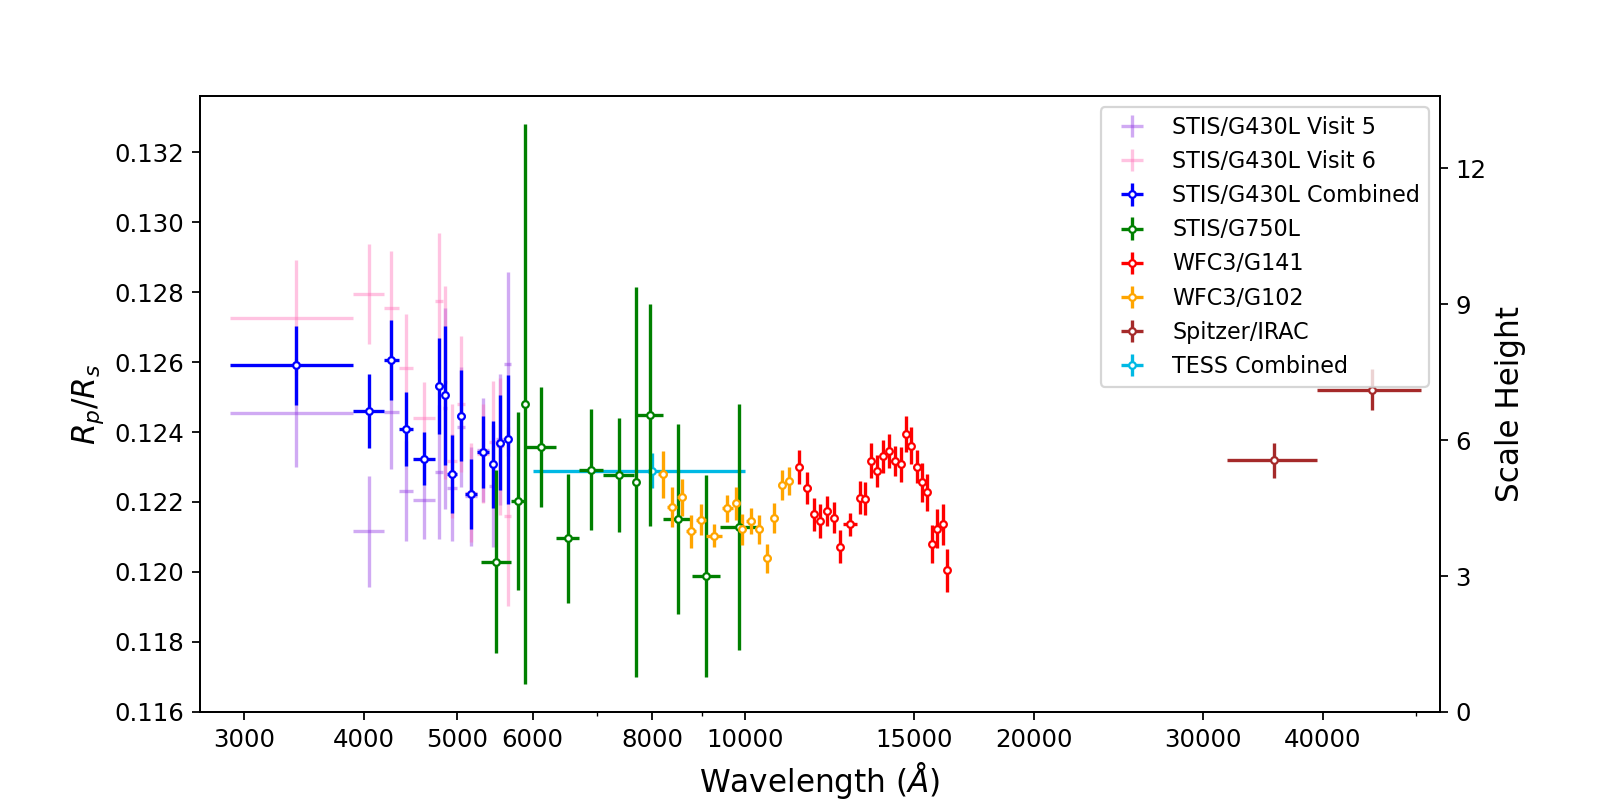

In [12]:
fig2, (ax1) = plt.subplots(1,figsize=(10,5))

ax1.errorbar(w_stis5,dat_stis5,xerr=we_stis5,yerr=date_stis5,ls='none',label='STIS/G430L Visit 5',color='blueviolet',alpha=0.4)
ax1.errorbar(w_stis6,dat_stis6,xerr=we_stis6,yerr=date_stis6,ls='none',label='STIS/G430L Visit 6',color='hotpink',alpha=0.4)
ax1.errorbar(w_stis4,dat_stis4,xerr=we_stis4,yerr=date_stis4,ls='none',label='STIS/G430L Combined',fmt='.',ecolor='b',color='white',mec='b')
ax1.errorbar(w_stis7,dat_stis7,xerr=we_stis7,yerr=date_stis7,ls='none',label='STIS/G750L',fmt='.',ecolor='g',color='white',mec='g')

ax1.errorbar(w_g141,rl_g141,xerr=we_g141,yerr=rle_g141,ls='none',label='WFC3/G141',fmt='.',ecolor='r',color='white',mec='r')
ax1.errorbar(w_g102,rl_g102,xerr=we_g102,yerr=rle_g102,ls='none',label='WFC3/G102',fmt='.',ecolor='orange',color='white',mec='orange')


ax1.errorbar(w_irac,dat_irac,xerr=we_irac,yerr=date_irac,ls='none',label='Spitzer/IRAC',fmt='.',ecolor='brown',color='white',mec='brown')

ax1.errorbar(8000,0.122895,xerr=2000, yerr=[[0.000487],[0.000502]], ls='none', label='TESS Combined', ecolor='#00B9E4',color='white',mec='#00B9E4',fmt='.',zorder=0)

yticks = ax1.get_yticks()
ax2 = ax1.twinx()

scale_height_tick_range = (yticks[-1]-yticks[0])/H_w17
ax2.set_ylim(0,scale_height_tick_range)
ax2.yaxis.set_major_locator(plt.MaxNLocator(5))

ax1.set_xlabel("Wavelength ($\AA$)", fontsize=14)
ax1.set_xlim(2700)#,16550)
ax1.set_xscale('log')
ax1.set_xscale('log')
ax1.set_xticks([3000, 4000, 5000, 6000, 8000, 10000,15000,20000,30000,40000])
ax1.get_xaxis().set_major_formatter(tck.ScalarFormatter())

ax1.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='both', which='major', labelsize=11)

ax1.set_ylabel("$R_p/R_s$", fontsize=14)
ax2.set_ylabel("Scale Height", fontsize=14)
ax1.legend()
plt.savefig("transmission_5mu.pdf", bbox_inches="tight")
plt.show()

<IPython.core.display.Javascript object>


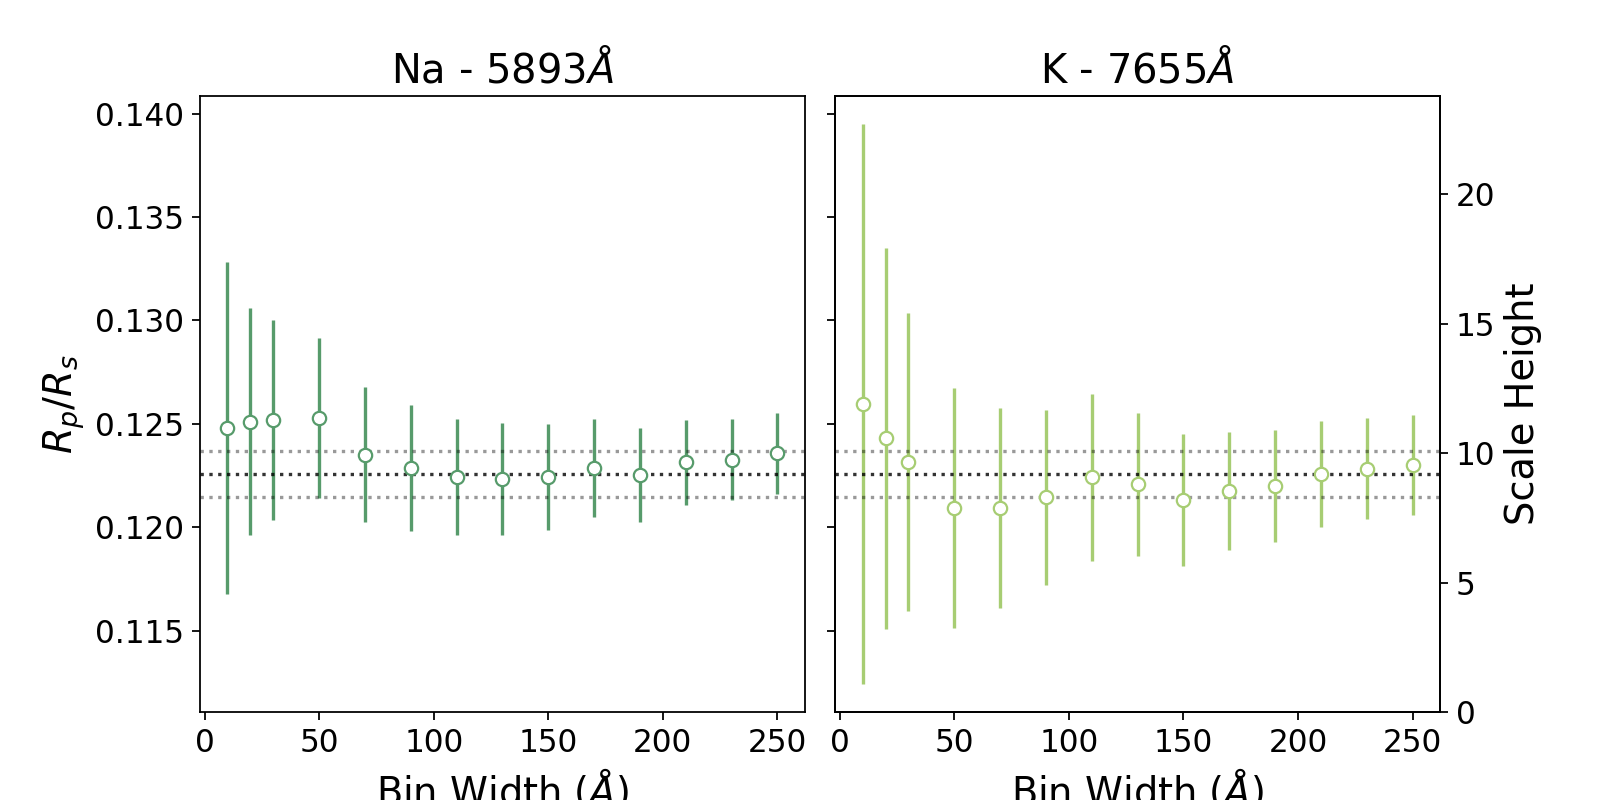

In [13]:
fig2, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)
plt.subplots_adjust(wspace = 0.05)

ax1.errorbar(width_Na_iic,dat_Na_iic,yerr=date_Na_iic,ls='none',label='Na',fmt='o',ecolor='#579b6b',color='white',mec='#579b6b')
ax2.errorbar(width_K_iic,dat_K_iic,yerr=date_K_iic,ls='none',label='K',fmt='o',ecolor='#a7cd73',color='white',mec='#a7cd73')

#ax1.errorbar(we_stis7[2],dat_stis7[2],yerr=date_stis7[2],ls='none',label='Na',fmt='x',ecolor='#579b6b',color='white',mec='#579b6b')
#ax2.errorbar(we_stis7[7],dat_stis7[7],yerr=date_stis7[7],ls='none',label='K',fmt='x',ecolor='#a7cd73',color='white',mec='#a7cd73')


yticks = ax2.get_yticks()
ax3 = ax2.twinx()

scale_height_tick_range = (yticks[-1]-yticks[0])/H_w17
ax3.set_ylim(0,scale_height_tick_range)
ax3.yaxis.set_major_locator(plt.MaxNLocator(5))

#ax1.set_xlim(23)
#ax2.set_xlim(23)

#ax1.set_ylim(0.115,0.133)
#ax2.set_ylim(0.115,0.133)

ax1.set_title("Na - "+str(int(w_Na_iic[0]))+"$\AA$", fontsize=18)
ax2.set_title("K - "+str(int(w_K_iic[0]))+"$\AA$", fontsize=18)


ax1.axhline(0.1225690, ls=':', c='k',alpha=0.8) #stis white light depth
ax1.axhline(0.1225690-0.0011237, ls=':', c='k',alpha=0.4)
ax1.axhline(0.1225690+0.0011237, ls=':', c='k',alpha=0.4)

ax2.axhline(0.1225690, ls=':', c='k',alpha=0.8) #stis white light depth
ax2.axhline(0.1225690-0.0011237, ls=':', c='k',alpha=0.4)
ax2.axhline(0.1225690+0.0011237, ls=':', c='k',alpha=0.4)

ax1.set_ylabel("$R_p/R_s$", fontsize='xx-large')
ax3.set_ylabel("Scale Height", fontsize='xx-large')
ax1.set_xlabel("Bin Width ($\AA$)\n Centered at "+str(int(w_Na_iic[0]))+"$\AA$", fontsize='xx-large')
ax2.set_xlabel("Bin Width ($\AA$)\n Centered at "+str(int(w_K_iic[0]))+"$\AA$", fontsize='xx-large')

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)


#ax1.errorbar(wSe[15],dat_S[15],yerr=dat_Se[15],fmt='o',ecolor='red',color='white',mec='red')

plt.show()
plt.savefig("iic_plots.pdf", bbox_inches='tight')


<IPython.core.display.Javascript object>


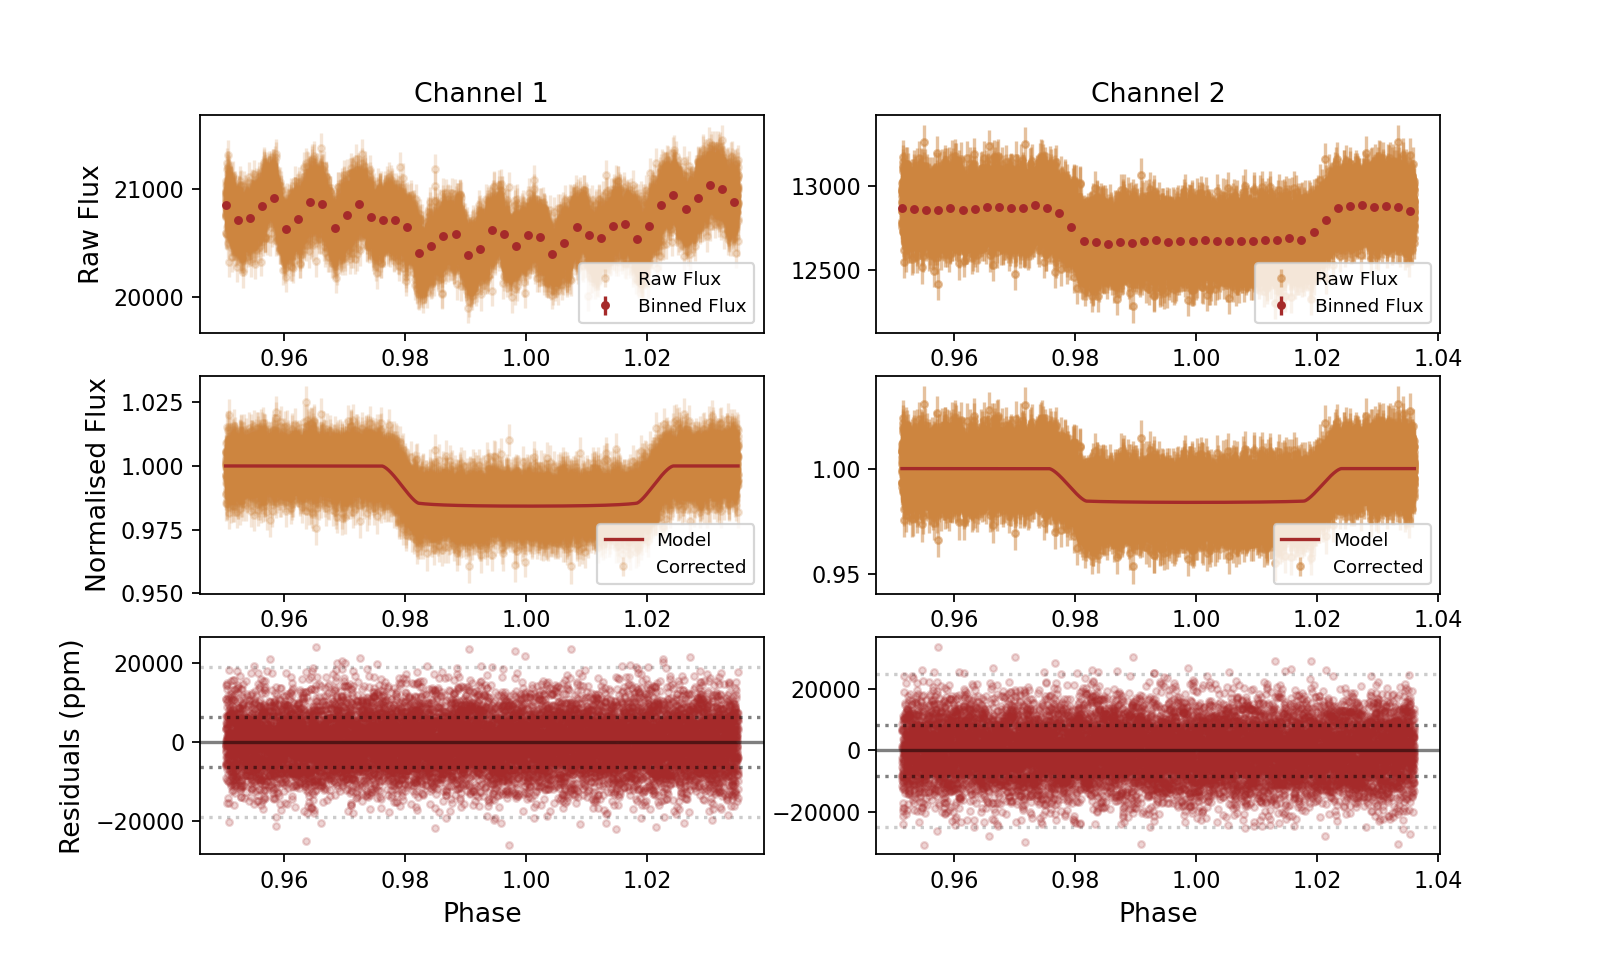

In [14]:
_,s1_bjdtdb,s1_phase,s1_flux_raw,s1_flux_norm,s1_sigma_raw,s1_sigma_norm,s1_bestfit_raw,s1_bestfit_norm = np.loadtxt('spitzer_ch1.csv', unpack=True, skiprows=1, delimiter=',')
_,s2_bjdtdb,s2_phase,s2_flux_raw,s2_flux_norm,s2_sigma_raw,s2_sigma_norm,s2_bestfit_raw,s2_bestfit_norm = np.loadtxt('spitzer_ch2.csv', unpack=True, skiprows=1, delimiter=',')

binned_ch1 = bt.binning(s1_phase, s1_flux_raw, dy = s1_sigma_raw, binwidth = 0.002)
s1_phase_binned, s1_flux_raw_binned, s1_sigma_raw_binned = binned_ch1['bin_x'], binned_ch1['bin_y'], binned_ch1['bin_dy']

binned_ch2 = bt.binning(s2_phase, s2_flux_raw, dy = s2_sigma_raw, binwidth = 0.002)
s2_phase_binned, s2_flux_raw_binned, s2_sigma_raw_binned = binned_ch2['bin_x'], binned_ch2['bin_y'], binned_ch2['bin_dy']


fig, axes = plt.subplots(3,2, figsize=(10,6))

axes[0,0].set_title("Channel 1")
axes[0,0].errorbar(s1_phase, s1_flux_raw, yerr=s1_sigma_raw, marker='.', ls='none', alpha=0.2, zorder=0, label='Raw Flux', color='peru', rasterized=True)
axes[0,0].errorbar(s1_phase_binned, s1_flux_raw_binned, yerr=s1_sigma_raw_binned, marker='.', ls='none', label='Binned Flux', zorder=0, color='brown', rasterized=True)
axes[0,0].set_ylabel('Raw Flux',fontsize="large")
axes[0,0].legend(loc='lower right',fontsize="small")

axes[1,0].errorbar(s1_phase, s1_flux_norm, yerr=s1_sigma_norm, marker='.', ls='none', alpha=0.2, label='Corrected', zorder=0,color='peru', rasterized=True)
axes[1,0].plot(s1_phase, s1_bestfit_norm, ls='-', zorder=1,color='brown', label='Model',rasterized=True)
axes[1,0].set_ylabel('Normalised Flux',fontsize="large")
axes[1,0].legend(loc='lower right',fontsize="small")

residual1=s1_bestfit_norm-s1_flux_norm
residual1_stdev = np.std(residual1)
residual1_stdev_ppm = residual1_stdev*1e6
residual1_ppm = residual1*1e6

axes[2,0].axhline(0, ls='-', alpha=0.5, color='k',rasterized=True)
axes[2,0].axhline(residual1_stdev_ppm, ls=':', alpha=0.5, color='k',rasterized=True)
axes[2,0].axhline(-residual1_stdev_ppm, ls=':', alpha=0.5, color='k',rasterized=True)
axes[2,0].axhline(residual1_stdev_ppm*3, ls=':', alpha=0.2, color='k',rasterized=True)
axes[2,0].axhline(-residual1_stdev_ppm*3, ls=':', alpha=0.2, color='k',rasterized=True)
axes[2,0].errorbar(s1_phase, residual1_ppm, marker='.', ls='none', alpha=0.2, zorder=0, color='brown', rasterized=True)
axes[2,0].set_ylabel('Residuals (ppm)',fontsize="large")
axes[2,0].set_xlabel('Phase',fontsize="large")


axes[0,1].set_title("Channel 2")
axes[0,1].errorbar(s2_phase, s2_flux_raw, yerr=s2_sigma_raw, marker='.', ls='none', alpha=0.5, zorder=0, label='Raw Flux', color='peru', rasterized=True)
axes[0,1].errorbar(s2_phase_binned, s2_flux_raw_binned, yerr=s2_sigma_raw_binned, marker='.', ls='none', label='Binned Flux', zorder=0, color='brown', rasterized=True)
axes[0,1].legend(loc='lower right',fontsize="small")

axes[1,1].errorbar(s2_phase, s2_flux_norm, yerr=s2_sigma_norm, marker='.', ls='none', label='Corrected', alpha=0.5, zorder=0,color='peru', rasterized=True)
axes[1,1].plot(s2_phase, s2_bestfit_norm, ls='-', zorder=1, label='Model', color='brown',rasterized=True)
axes[1,1].legend(loc='lower right',fontsize="small")

residual2=s2_bestfit_norm-s2_flux_norm
residual2_stdev = np.std(residual2)
residual2_stdev_ppm = residual2_stdev*1e6
residual2_ppm = residual2*1e6

axes[2,1].axhline(0, ls='-', alpha=0.5, color='k',rasterized=True)
axes[2,1].axhline(residual2_stdev_ppm, ls=':', alpha=0.5, color='k',rasterized=True)
axes[2,1].axhline(-residual2_stdev_ppm, ls=':', alpha=0.5, color='k',rasterized=True)
axes[2,1].axhline(residual2_stdev_ppm*3, ls=':', alpha=0.2, color='k',rasterized=True)
axes[2,1].axhline(-residual2_stdev_ppm*3, ls=':', alpha=0.2, color='k',rasterized=True)
axes[2,1].errorbar(s2_phase, residual2_ppm, marker='.', ls='none', alpha=0.2, zorder=0, color='brown', rasterized=True)
axes[2,1].set_xlabel('Phase',fontsize="large")

plt.show()
plt.savefig("spitzer_wlc.pdf", bbox_inches='tight', dpi=400)

In [15]:
def pretty_wlcs(folder_list, colors, labels, savefig=False, output_name="WFC3", figure_path='../../papers/WASP_17b_2021/', plot_output=True):
    """
    Generates a 3 panel figure of raw light curves, cleaned light curves + model, 
    & residuals with residual stdev and wavelength centre printed underneath.
    
    Inputs: 
    - folder_list (list)
        list of paths pointing to outputs folders of exoticism, e.g. '../../ExoTiCISM/outputs/470_refit/2021-04-29T14-06-07_W17_470_refit_time'
    - colors (list)
        list of colours to plot the light curves in
    - labels (list)
        list of labels for each light curve (e.g., ['G102 v2', 'G102 v32'])
    - savefig (bool, default=False)
        whether to save the figure or not
    - output_name (str)
        what to call the file 
    - figure_path (str, default='../../papers/WASP_17b_2021')
        where to save the figure
    - plot_output (bool, default=True)
        whether to display figure via plt.show()
    """
    
    axes_go = False
    if savefig == True:
        axes_go = True
    if plot_output == True:
        axes_go = True
        
    if axes_go == True:
        fig, axes = plt.subplots(3, len(folder_list), figsize=(10,6))
        plt.subplots_adjust(wspace=None, hspace=0.15)

    count=0

    N = len(folder_list)  # Number of wavelength bins

    for folder in folder_list:
        
        first_phase, first_flux, first_e, _ = np.loadtxt(str(folder)+'/raw_wlc.txt', unpack=True)
        
        best_sys = np.load(str(folder)+'/marginalization_results.npz')['best_sys']
        
        sys_residuals = np.load(str(folder)+'/full-fit.npz')['sys_residuals'][best_sys]

        sys_flux = np.load(str(folder)+'/full-fit.npz')['sys_flux'][best_sys]
        sys_flux_err = np.load(str(folder)+'/full-fit.npz')['sys_flux_err'][best_sys]
        
        sys_phase = np.load(str(folder)+'/full-fit.npz')['sys_phase'][best_sys]
        
        sys_model = np.load(str(folder)+'/full-fit.npz')['sys_model'][best_sys]
        sys_model_phase = np.load(str(folder)+'/full-fit.npz')['sys_model_phase'][best_sys]
        
        sys_rawflux = np.load(str(folder)+'/full-fit.npz')['sys_rawflux'][best_sys]
        sys_rawflux_err = np.load(str(folder)+'/full-fit.npz')['sys_rawflux_err'][best_sys]

        #all_residuals[:,count] = sys_residuals
        
        residual_stdev = np.std(sys_residuals)
        residual_stdev_ppm = residual_stdev*1e6
        sys_residuals_ppm = sys_residuals*1e6

        xlim_min = np.min(first_phase) - 0.004
        xlim_max = np.max(first_phase) + 0.008

        if axes_go == True: 
            #axes[0, count].errorbar(sys_phase,(sys_rawflux),yerr=sys_rawflux_err,marker='.',ls='none',label="rawflux",alpha=1,c=colors[count])
            axes[0, count].errorbar(first_phase,first_flux,yerr=first_e,marker='.',ls='none',label="Raw Flux",alpha=0.6,c=colors[count])
            #axes[0, count].errorbar(sys_phase,sys_rawflux,marker='.',ls='none',label="Raw Flux",alpha=1,c=colors[count])
            axes[0, count].plot(sys_phase,(sys_rawflux),ls='-',alpha=1,c=colors[count])
            axes[0, count].set_title(labels[count])
            axes[0, count].set_xlim(xlim_min, xlim_max)
            axes[0, count].legend(loc='lower right',fontsize="small")
            axes[0, count].tick_params(axis='y', labelsize='small')
            axes[0, count].tick_params(axis='x',which='both',top=False,bottom=False,labelbottom=False)
            if count == 0:
                axes[0, count].set_ylabel("Normalised Flux",fontsize="large")
                
            #else:
                #axes[0, count].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
            

            axes[1, count].errorbar(sys_phase,(sys_flux),yerr=sys_flux_err,marker='.',ls='none',label="Corrected",alpha=1,c=colors[count])
            axes[1, count].plot(sys_model_phase,(sys_model),ls='-',label="Model",alpha=1,c=colors[count])
            axes[1, count].set_xlim(xlim_min, xlim_max)
            axes[1, count].legend(loc='lower left',fontsize="small")
            axes[1, count].tick_params(axis='y', labelsize='small')
            axes[1, count].tick_params(axis='x',which='both',top=False,bottom=False,labelbottom=False)
            if count == 0:
                axes[1, count].set_ylabel("Normalised Flux",fontsize="large")
            
            


            axes[2, count].axhline(0, ls='-', alpha=0.5, color='k')
            axes[2, count].axhline(residual_stdev_ppm, ls=':', alpha=0.5, color='k')
            axes[2, count].axhline(-residual_stdev_ppm, ls=':', alpha=0.5, color='k')
            axes[2, count].axhline(residual_stdev_ppm*3, ls=':', alpha=0.2, color='k')
            axes[2, count].axhline(-residual_stdev_ppm*3, ls=':', alpha=0.2, color='k')
            axes[2, count].set_xlim(xlim_min, xlim_max)
            axes[2, count].errorbar(sys_phase,sys_residuals_ppm,marker='.',ls='none',label="flux",alpha=1,c=colors[count])
            axes[2, count].tick_params(axis='y', labelsize='small')
            axes[2, count].tick_params(axis='x', labelsize='small')
            #axes[2, count].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
            if count == 0:
                axes[2, count].set_ylabel("Residuals (ppm)",fontsize="large")
            axes[2, count].set_xlabel("Phase",fontsize="large")
            #axes[2, count].annotate((str(int(residual_stdev_ppm))+"ppm"),xy=(0,0),fontsize='medium')

        count+=1

    #axes[0].set_ylim(np.min(sys_rawflux-(count-1)*squishfactor)-0.003,1.005)

    if savefig == True:
        plt.savefig(figure_path+output_name+"_pretty_wlcs.pdf",bbox_inches='tight')
    if plot_output == True:
        plt.show()
        
    #return(all_residuals, wave_mid, wave_half_width)

<IPython.core.display.Javascript object>


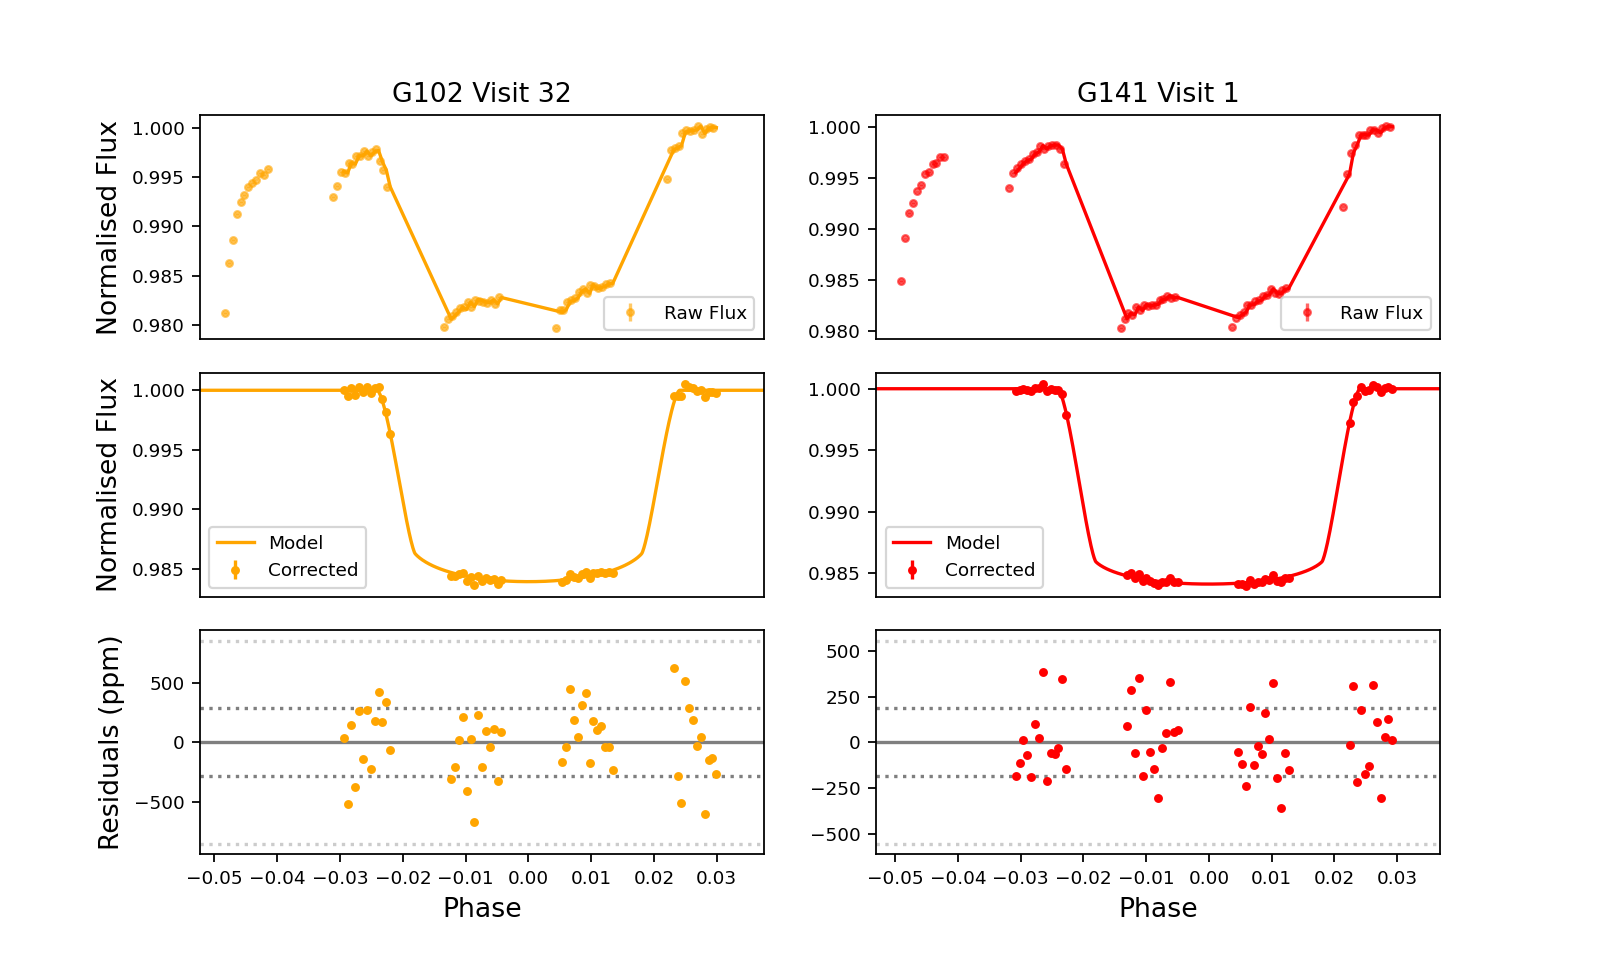

In [16]:
wlc_list = ['/Users/lilialderson/Documents/papers/WASP_17b_2021/github/FINAL_PERIOD_wlc/2021-07-05T12-05-06_W17_g102_clipped','/Users/lilialderson/Documents/papers/WASP_17b_2021/github/FINAL_PERIOD_wlc/2021-07-05T12-09-09_W17_g141']
labels = ['G102 Visit 32', 'G141 Visit 1']
colors = ['orange','r']

pretty_wlcs(wlc_list, colors, labels, savefig=True, output_name="WFC3", figure_path='/Users/lilialderson/Documents/papers/WASP_17b_2021/github/', plot_output=True)

In [17]:
def pretty_wlcs_STIS(folders_loc, colors, labels, savefig=False, output_name="WFC3", figure_path='../../papers/WASP_17b_2021/', plot_output=True):
    """
    Generates a 3 panel figure of raw light curves, cleaned light curves + model, 
    & residuals with residual stdev and wavelength centre printed underneath.
    
    Can also save residual map if required via residuals_plot = True
    
    Inputs: 
    - folders_loc (str)
        location of STIS files, e.g., "../../HST/WASP_17b/transit/STIS/G430L_Visit5/"
    - colors (list)
        list of colours to plot the light curves in
    - labels (list)
        list of labels for each light curve (e.g., ['G102 v2', 'G102 v32'])
    - savefig (bool, default=False)
        whether to save the figure or not
    - output_name (str)
        what to call the file 
    - figure_path (str, default='../../papers/WASP_17b_2021')
        where to save the figure
    - plot_output (bool, default=True)
        whether to display figure via plt.show()
    """
    
    axes_go = False
    if savefig == True:
        axes_go = True
    if plot_output == True:
        axes_go = True

    models_list = glob.glob(folders_loc+'*_model.txt')
    models_list.sort()

    lcs_list = glob.glob(folders_loc+'*_lightcurve.txt')
    lcs_list.sort()
    
    lcs_full_list = glob.glob(folders_loc+'*_lightcurve_full.txt')
    lcs_full_list.sort()
    
    if axes_go == True:
        fig, axes = plt.subplots(3, len(lcs_list), figsize=(10,6))
        plt.subplots_adjust(wspace=None, hspace=0.15)

    count=0

    N = len(lcs_list)  # Number of light curves

    for i in range(N):

        sys_phase, sys_rawflux, sys_rawflux_err, sys_flux, sys_flux_err, sys_residuals = np.loadtxt(lcs_list[i],unpack=True)
        first_phase, first_flux, first_e = np.loadtxt(lcs_full_list[i], unpack=True)
        sys_model_phase, sys_model = np.loadtxt(models_list[i],unpack=True)
        
        #print(lcs_full_list[i])
        #print(lcs_list[i])
        #print(models_list[i])
        
        norm_flux = first_flux / first_flux[10]
        norm_e = first_e / first_flux[10]

        residual_stdev = np.std(sys_residuals)# +1
        residual_stdev_ppm = residual_stdev*1e6
        sys_residuals_ppm = sys_residuals*1e6

        xlim_min = np.min(first_phase) - 0.005
        xlim_max = np.max(first_phase) + 0.005

        if axes_go == True:
            #axes[0, count].errorbar(sys_phase,(sys_rawflux),yerr=sys_rawflux_err,marker='.',ls='none',label="rawflux",alpha=1,c=colors[count])
            axes[0, count].errorbar(first_phase,norm_flux,yerr=norm_e,marker='.',ls='none',label="Raw Flux",alpha=1,c=colors[count])
            axes[0, count].plot(sys_phase,(sys_rawflux),ls='-',alpha=1,c=colors[count])
            axes[0, count].set_title(labels[count])
            axes[0, count].set_xlim(xlim_min, xlim_max)
            axes[0, count].legend(loc='center left',fontsize="x-small")
            axes[0, count].tick_params(axis='y', labelsize='small')
            axes[0, count].tick_params(axis='x',which='both',top=False,bottom=False,labelbottom=False)
            if count == 0:
                axes[0, count].set_ylabel("Normalised Flux",fontsize="large")

            axes[1, count].errorbar(sys_phase,(sys_flux),yerr=sys_flux_err,marker='.',ls='none',label="Corrected",alpha=1,c=colors[count])
            axes[1, count].plot(sys_model_phase,(sys_model),ls='-',label="Model",alpha=1,c=colors[count])
            axes[1, count].set_xlim(xlim_min, xlim_max)
            axes[1, count].tick_params(axis='y', labelsize='small')
            axes[1, count].legend(loc='center left',fontsize="x-small")
            axes[1, count].tick_params(axis='x',which='both',top=False,bottom=False,labelbottom=False)
            if count == 0:
                axes[1, count].set_ylabel("Normalised Flux",fontsize="large")

            axes[2, count].axhline(0, ls='-', alpha=0.5, color='k')
            axes[2, count].axhline(residual_stdev_ppm, ls=':', alpha=0.5, color='k')
            axes[2, count].axhline(-residual_stdev_ppm, ls=':', alpha=0.5, color='k')
            axes[2, count].axhline(residual_stdev_ppm*3, ls=':', alpha=0.2, color='k')
            axes[2, count].axhline(-residual_stdev_ppm*3, ls=':', alpha=0.2, color='k')
            axes[2, count].set_xlim(xlim_min, xlim_max)
            axes[2, count].errorbar(sys_phase,sys_residuals_ppm,marker='.',ls='none',label="flux",alpha=1,c=colors[count])
            axes[2, count].tick_params(axis='y', labelsize='small')
            axes[2, count].tick_params(axis='x', labelsize='small')
            if count == 0:
                axes[2, count].set_ylabel("Residuals (ppm)",fontsize="large")
            axes[2, 1].set_xlabel("Phase",fontsize="large")
        count+=1

    #axes[0].set_ylim(np.min(sys_rawflux-(count-1)*squishfactor)-0.003,1.005)

    if savefig == True:
        plt.savefig(figure_path+output_name+"_pretty_wlcs.pdf",bbox_inches='tight')
    if plot_output == True:
        plt.show()

<IPython.core.display.Javascript object>


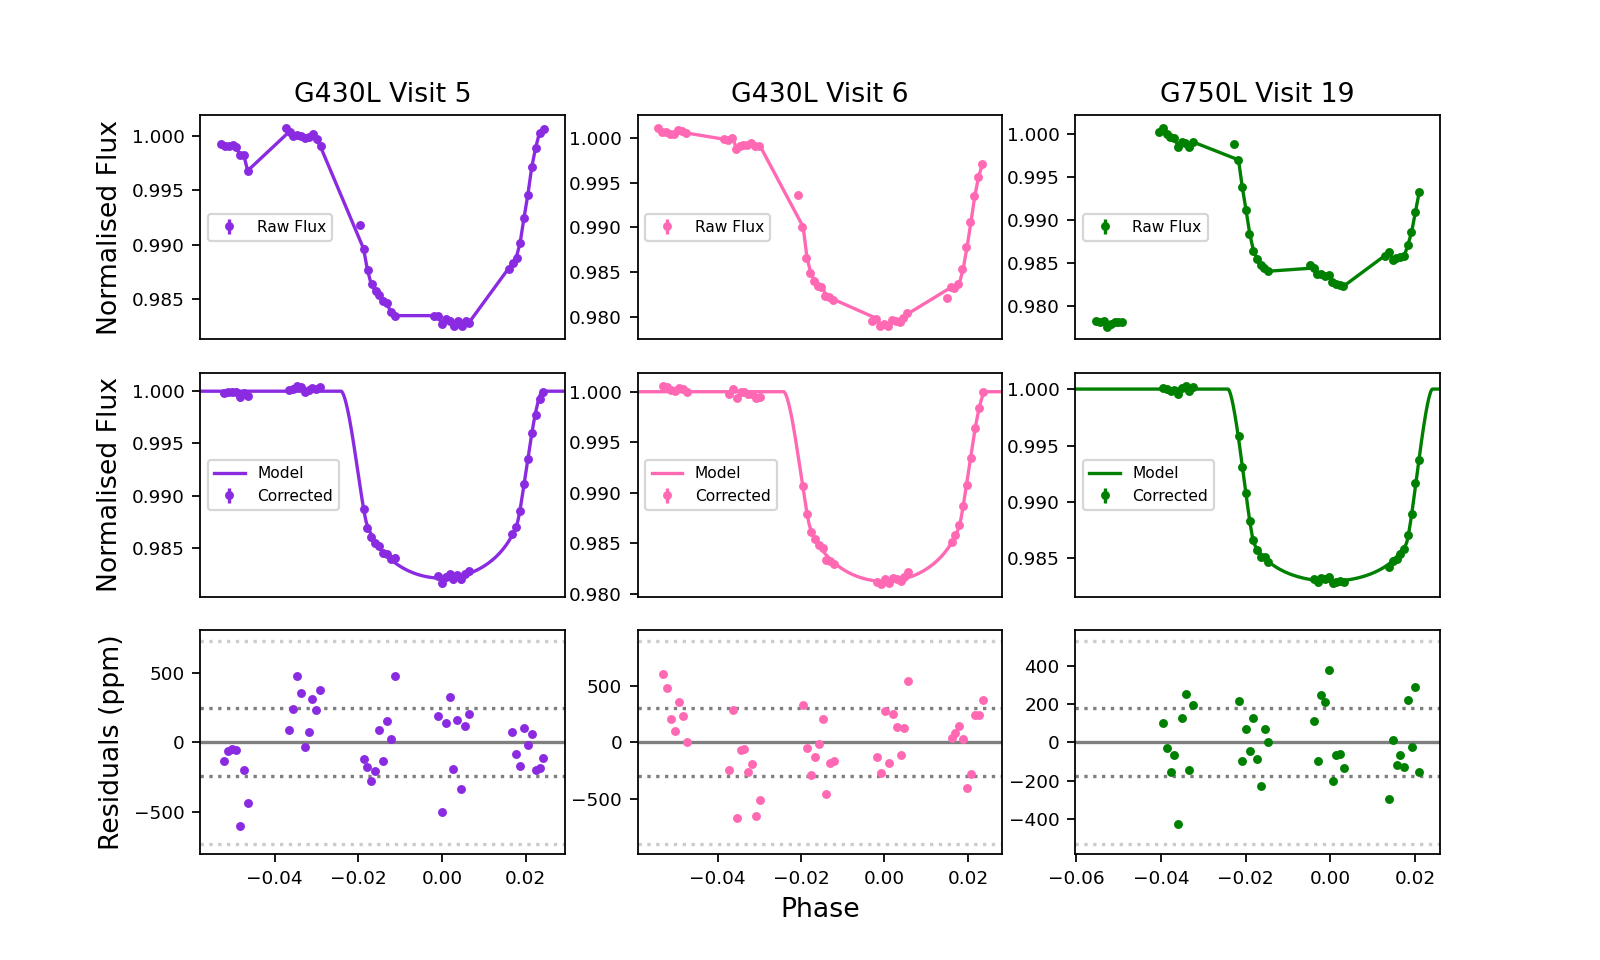

In [18]:
colors = ['blueviolet','hotpink','g']
labels = ['G430L Visit 5', 'G430L Visit 6', 'G750L Visit 19']

pretty_wlcs_STIS('/Users/lilialderson/Documents/papers/WASP_17b_2021/github/FINAL_PERIOD_STIS_wlc/', colors, labels, savefig=True, output_name="STIS", figure_path='/Users/lilialderson/Documents/papers/WASP_17b_2021/github/', plot_output=True)


In [19]:
def pretty_lcs(folder_list, savefig=False, mode="G102", figure_path='../../papers/WASP_17b_2021/', plot_output=True, palette='flare', squishfactor=0.01, residuals_plot=False):
    """
    Generates a 3 panel figure of raw light curves, cleaned light curves + model, 
    & residuals with residual stdev and wavelength centre printed underneath.
    
    Inputs: 
    - folder_list (list)
        list of paths pointing to outputs folders of exoticism, e.g. '../../ExoTiCISM/outputs/470_refit/2021-04-29T14-06-07_W17_470_refit_time'
    - savefig (bool, default=False)
        whether to save the figure or not
    - mode (str, default='G102')
        filter mode for file save name
    - figure_path (str, default='../../papers/WASP_17b_2021')
        where to save the figure
    - plot_output (bool, default=True)
        whether to display figure via plt.show()
    - palette (str, default='flare')
        seaborn color palette to use for plotting
    - squishfactor (float, default='0.01')
        how much to offset each light curve, likely will only need changing if transit is particularly deep or raw light curves are particularly messy
    - residuals_plot (bool default=False)
        saves residual map as pdf
    
    Seaborn options (+ all '_r' versions):
    'Accent', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap',  'Dark2', 'GnBu', 'Greens', 'Greys', 'OrRd', 
    'Oranges', 'PRGn', 'Paired', 'Pastel1', 'Pastel2', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 
    'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Set1', 'Set2', 'Set3', 'Spectral', 'Wistia', 'YlGn', 
    'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cividis', 'cool', 
    'coolwarm', 'copper', 'crest', 'cubehelix', 'flag', 'flare', 'gist_earth', 'gist_gray', 'gist_heat', 
    'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 
    'icefire', 'inferno', 'jet', 'magma', 'mako', 'nipy_spectral', 'ocean', 'pink', 'plasma', 'prism', 
    'rainbow', 'rocket', 'seismic', 'spring', 'summer', 'terrain', 'turbo', 'twilight', 'twilight_shifted', 
    'viridis', 'vlag', 'winter'
    """
    
    axes_go = False
    if savefig == True:
        axes_go = True
    if plot_output == True:
        axes_go = True
        
    if axes_go == True:
        fig, axes = plt.subplots(1, 3, figsize=(8,10),sharey=True)

    residual_len = len(np.load(str(folder_list[0])+'/full-fit.npz')['sys_residuals'][0])
    all_residuals = np.zeros((residual_len,len(folder_list)))
    
    wave_mid=[]
    wave_half_width=[]

    count=0

    N = len(folder_list)  # Number of wavelength bins
    colors = np.array(sns.color_palette(palette, N))

    for folder in folder_list:
        best_sys = np.load(str(folder)+'/marginalization_results.npz')['best_sys']
        
        wave_mid.append(np.load(str(folder)+'/marginalization_results.npz')['wave_mid'])
        wave_half_width.append(np.load(str(folder)+'/marginalization_results.npz')['wave_half_width'])
        
        sys_residuals = np.load(str(folder)+'/full-fit.npz')['sys_residuals'][best_sys]

        sys_flux = np.load(str(folder)+'/full-fit.npz')['sys_flux'][best_sys]
        sys_flux_err = np.load(str(folder)+'/full-fit.npz')['sys_flux_err'][best_sys]
        
        sys_phase = np.load(str(folder)+'/full-fit.npz')['sys_phase'][best_sys]
        
        sys_model = np.load(str(folder)+'/full-fit.npz')['sys_model'][best_sys]
        sys_model_phase = np.load(str(folder)+'/full-fit.npz')['sys_model_phase'][best_sys]
        
        sys_rawflux = np.load(str(folder)+'/full-fit.npz')['sys_rawflux'][best_sys]
        sys_rawflux_err = np.load(str(folder)+'/full-fit.npz')['sys_rawflux_err'][best_sys]

        all_residuals[:,count] = sys_residuals
        
        residual_stdev = np.std(sys_residuals)
        residual_stdev_ppm = residual_stdev*1e6

        xlim_min = np.min(sys_phase) - 0.005
        xlim_max = np.max(sys_phase) + 0.005

        if axes_go == True: 
            axes[0].errorbar(sys_phase,(sys_rawflux-count*squishfactor),yerr=sys_rawflux_err,marker='.',ls='none',label="rawflux",alpha=1,c=colors[count])
            axes[0].plot(sys_phase,(sys_rawflux-count*squishfactor),ls='-',label="rawflux",alpha=1,c=colors[count])
            axes[0].set_ylabel("Normalised Flux",fontsize="x-large")
            axes[0].tick_params(axis='y', labelsize='large')
            axes[0].tick_params(axis='x', labelsize='large')

            axes[1].errorbar(sys_phase,(sys_flux-count*squishfactor),yerr=sys_flux_err,marker='.',ls='none',label="flux",alpha=1,c=colors[count])
            axes[1].plot(sys_model_phase,(sys_model-count*squishfactor),ls='-',label="model",alpha=1,c=colors[count])
            axes[1].set_xlim(xlim_min, xlim_max)
            axes[1].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
            axes[1].set_xlabel("Phase",fontsize="x-large")
            axes[1].tick_params(axis='x', labelsize='large')

            axes[2].axhline((1-count*squishfactor), ls='-', alpha=0.5, color='k')
            axes[2].errorbar(sys_phase,(1+(sys_residuals)-count*squishfactor),marker='.',ls='none',label="flux",alpha=1,c=colors[count])
            axes[2].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
            axes[2].tick_params(axis='x', labelsize='large')
            axes[2].annotate((str(int(wave_mid[count]))+"$\AA$"),xy=(np.min(sys_phase),(1-count*squishfactor-0.4*squishfactor)),fontsize='small')
            axes[2].annotate((str(int(residual_stdev_ppm))+"ppm"),xy=(0,(1-count*squishfactor-0.4*squishfactor)),fontsize='small')

        count+=1

    #axes[0].set_ylim(np.min(sys_rawflux-(count-1)*squishfactor)-0.003,1.005)

    if savefig == True:
        plt.savefig(figure_path+mode+"_pretty_slcs.pdf",bbox_inches='tight')
    if plot_output == True:
        plt.show()
        
    if residuals_plot == True:
        frames, bins = np.shape(all_residuals)
        frame_nos = np.arange(1,frames+1)
        colorrange = np.max([abs(np.amin(all_residuals)),abs(np.amax(all_residuals))])
        
        plt.figure(figsize=(7,5))
        im = plt.pcolormesh(wave_mid,frame_nos,(all_residuals*1e6), cmap='Spectral',edgecolors='face', shading='auto',vmin=-(colorrange*1e6), vmax=(colorrange*1e6))
        plt.ylabel("Frame Number")
        plt.xlabel("Wavelength ($\AA$)")#($\mu$m)")
        colorbar(im, "Residuals (ppm)")
        plt.savefig(figure_path+mode+"_residual_map.pdf",bbox_inches='tight')
        
    return(all_residuals, wave_mid, wave_half_width)

<IPython.core.display.Javascript object>


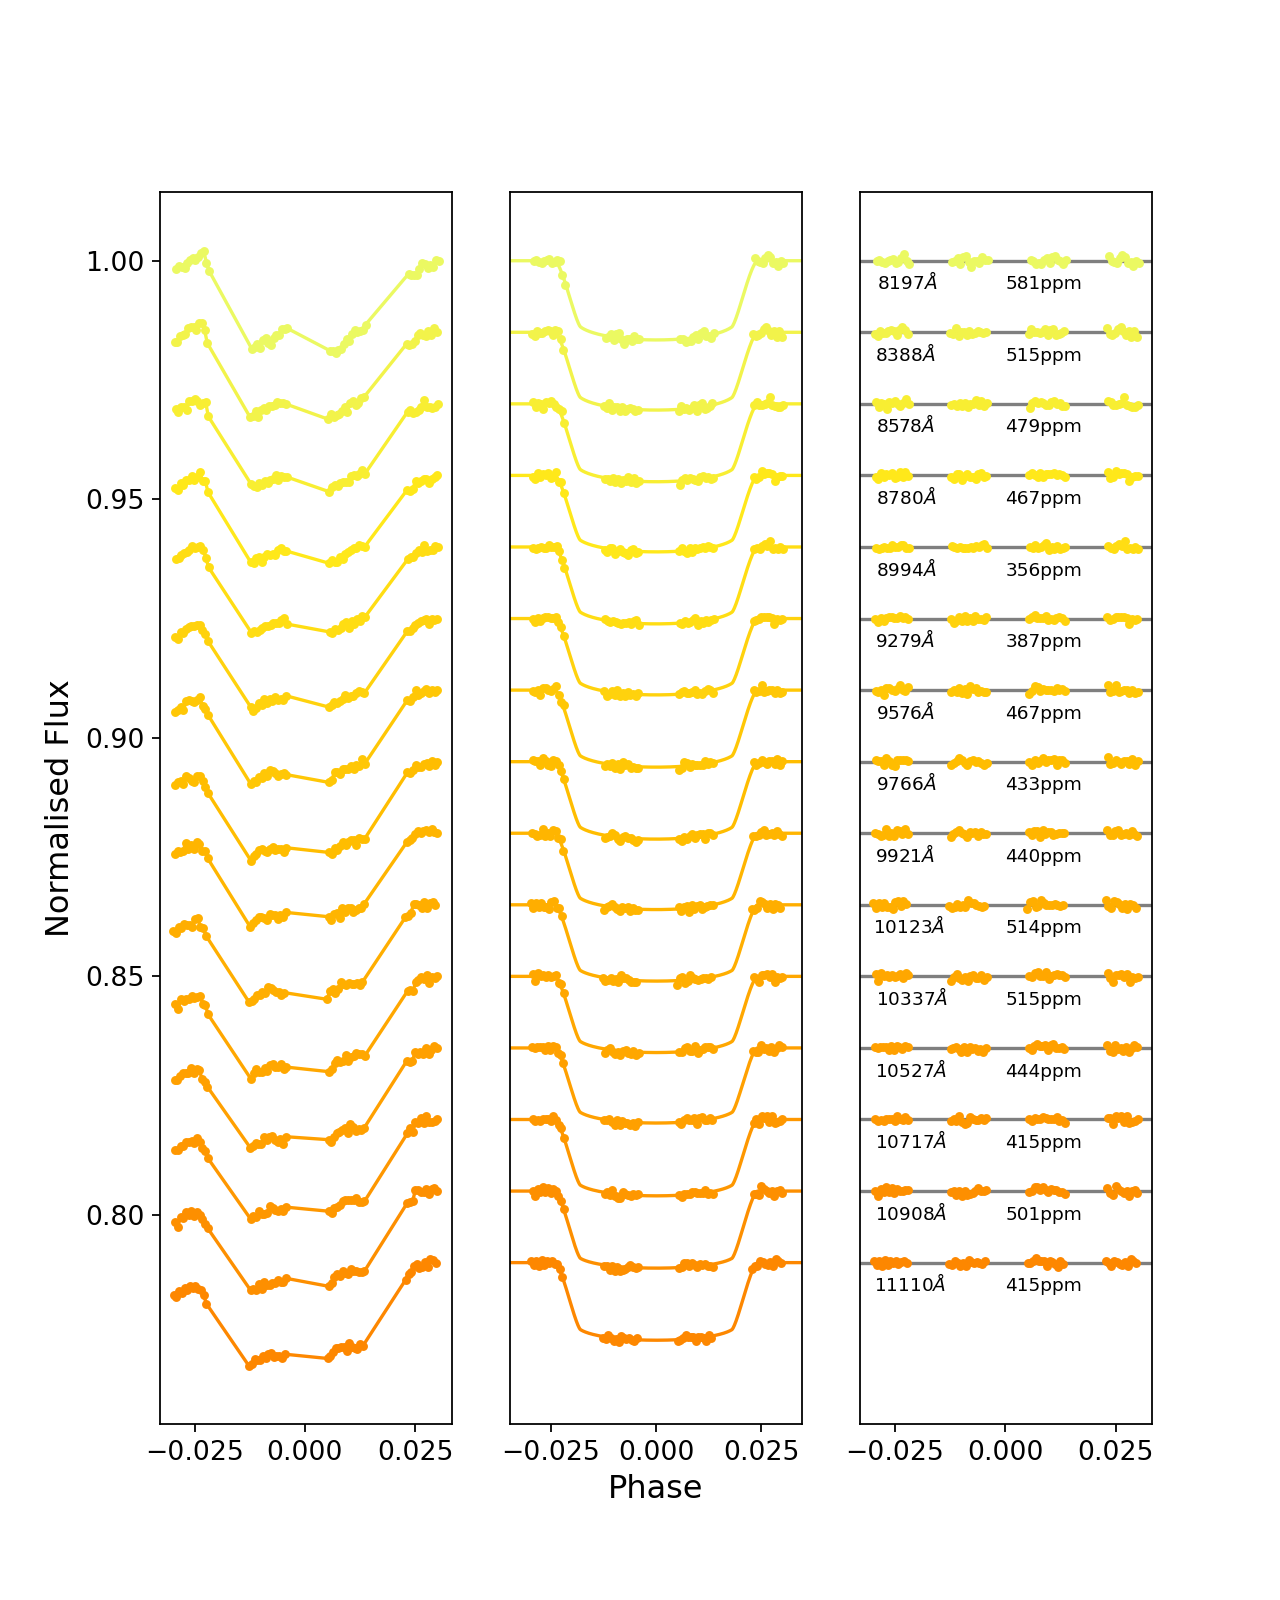

In [20]:
g102_resid, g102_wave, g102_hw = pretty_lcs(folders_g102, savefig=False, mode="WFC3_G102", figure_path='/Users/lilialderson/Documents/papers/WASP_17b_2021/github/', plot_output=True, palette='Wistia', squishfactor=0.015, residuals_plot=False)

In [21]:
def pretty_lcs_2panel(folder_list, savefig=False, mode="G102", figure_path='../../papers/WASP_17b_2021/', plot_output=True, palette='flare', squishfactor=0.01, residuals_plot=False, split_no=13):

    axes_go = False
    if savefig == True:
        axes_go = True
    if plot_output == True:
        axes_go = True
        
    if axes_go == True:
        fig, axes = plt.subplots(1, 6, figsize=(14,8),sharey=True)

    residual_len = len(np.load(str(folder_list[0])+'/full-fit.npz')['sys_residuals'][0])
    all_residuals = np.zeros((residual_len,len(folder_list)))
    
    wave_mid=[]
    wave_half_width=[]

    count=0
    count2=0

    N = len(folder_list)  # Number of wavelength bins
    colors = np.array(sns.color_palette(palette, N))

    for folder in folder_list:
        best_sys = np.load(str(folder)+'/marginalization_results.npz')['best_sys']
        
        wave_mid.append(np.load(str(folder)+'/marginalization_results.npz')['wave_mid'])
        wave_half_width.append(np.load(str(folder)+'/marginalization_results.npz')['wave_half_width'])
        
        sys_residuals = np.load(str(folder)+'/full-fit.npz')['sys_residuals'][best_sys]

        sys_flux = np.load(str(folder)+'/full-fit.npz')['sys_flux'][best_sys]
        sys_flux_err = np.load(str(folder)+'/full-fit.npz')['sys_flux_err'][best_sys]
        
        sys_phase = np.load(str(folder)+'/full-fit.npz')['sys_phase'][best_sys]
        
        sys_model = np.load(str(folder)+'/full-fit.npz')['sys_model'][best_sys]
        sys_model_phase = np.load(str(folder)+'/full-fit.npz')['sys_model_phase'][best_sys]
        
        sys_rawflux = np.load(str(folder)+'/full-fit.npz')['sys_rawflux'][best_sys]
        sys_rawflux_err = np.load(str(folder)+'/full-fit.npz')['sys_rawflux_err'][best_sys]

        all_residuals[:,count] = sys_residuals
        
        residual_stdev = np.std(sys_residuals)
        residual_stdev_ppm = residual_stdev*1e6

        xlim_min = np.min(sys_phase) - 0.005
        xlim_max = np.max(sys_phase) + 0.005

        if axes_go == True: 
            if count < split_no:
                axes[0].errorbar(sys_phase,(sys_rawflux-count*squishfactor),yerr=sys_rawflux_err,marker='.',ls='none',label="rawflux",alpha=1,c=colors[count])
                axes[0].plot(sys_phase,(sys_rawflux-count*squishfactor),ls='-',label="rawflux",alpha=1,c=colors[count])
                axes[0].set_ylabel("Normalised Flux",fontsize="x-large")
                axes[0].tick_params(axis='y', labelsize='large')
                axes[0].tick_params(axis='x', labelsize='large')

                axes[1].errorbar(sys_phase,(sys_flux-count*squishfactor),yerr=sys_flux_err,marker='.',ls='none',label="flux",alpha=1,c=colors[count])
                axes[1].plot(sys_model_phase,(sys_model-count*squishfactor),ls='-',label="model",alpha=1,c=colors[count])
                axes[1].set_xlim(xlim_min, xlim_max)
                axes[1].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
                axes[1].set_xlabel("Phase",fontsize="x-large")
                axes[1].tick_params(axis='x', labelsize='large')

                axes[2].axhline((1-count*squishfactor), ls='-', alpha=0.5, color='k')
                axes[2].errorbar(sys_phase,(1+(sys_residuals)-count*squishfactor),marker='.',ls='none',label="flux",alpha=1,c=colors[count])
                axes[2].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
                axes[2].tick_params(axis='x', labelsize='large')
                axes[2].annotate((str(int(wave_mid[count]))+"$\AA$"),xy=(np.min(sys_phase),(1-count*squishfactor-0.4*squishfactor)),fontsize='small')
                axes[2].annotate((str(int(residual_stdev_ppm))+"ppm"),xy=(0,(1-count*squishfactor-0.4*squishfactor)),fontsize='small')
            if count >= split_no:
                axes[3].errorbar(sys_phase,(sys_rawflux-count2*squishfactor),yerr=sys_rawflux_err,marker='.',ls='none',label="rawflux",alpha=1,c=colors[count])
                axes[3].plot(sys_phase,(sys_rawflux-count2*squishfactor),ls='-',label="rawflux",alpha=1,c=colors[count])
                axes[3].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
                axes[3].tick_params(axis='x', labelsize='large')

                axes[4].errorbar(sys_phase,(sys_flux-count2*squishfactor),yerr=sys_flux_err,marker='.',ls='none',label="flux",alpha=1,c=colors[count])
                axes[4].plot(sys_model_phase,(sys_model-count2*squishfactor),ls='-',label="model",alpha=1,c=colors[count])
                axes[4].set_xlim(xlim_min, xlim_max)
                axes[4].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
                axes[4].set_xlabel("Phase",fontsize="x-large")
                axes[4].tick_params(axis='x', labelsize='large')

                axes[5].axhline((1-count2*squishfactor), ls='-', alpha=0.5, color='k')
                axes[5].errorbar(sys_phase,(1+(sys_residuals)-count2*squishfactor),marker='.',ls='none',label="flux",alpha=1,c=colors[count])
                axes[5].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
                axes[5].tick_params(axis='x', labelsize='large')
                axes[5].annotate((str(int(wave_mid[count]))+"$\AA$"),xy=(np.min(sys_phase),(1-count2*squishfactor-0.4*squishfactor)),fontsize='small')
                axes[5].annotate((str(int(residual_stdev_ppm))+"ppm"),xy=(0,(1-count2*squishfactor-0.4*squishfactor)),fontsize='small')
                count2+=1
                
        count+=1

    #axes[0].set_ylim(np.min(sys_rawflux-(count-1)*squishfactor)-0.003,1.005)

    if savefig == True:
        plt.savefig(figure_path+mode+"_pretty_slcs.pdf",bbox_inches='tight')
    if plot_output == True:
        plt.show()
        
    if residuals_plot == True:
        frames, bins = np.shape(all_residuals)
        frame_nos = np.arange(1,frames+1)
        colorrange = np.max([abs(np.amin(all_residuals)),abs(np.amax(all_residuals))])
        
        plt.figure(figsize=(7,5))
        im = plt.pcolormesh(wave_mid,frame_nos,(all_residuals*1e6), cmap='Spectral',edgecolors='face', shading='auto',vmin=-(colorrange*1e6), vmax=(colorrange*1e6))
        plt.ylabel("Frame Number")
        plt.xlabel("Wavelength ($\AA$)")#($\mu$m)")
        colorbar(im, "Residuals (ppm)")
        plt.savefig(figure_path+mode+"_residual_map.pdf",bbox_inches='tight')
        
    return(all_residuals, wave_mid, wave_half_width)

<IPython.core.display.Javascript object>


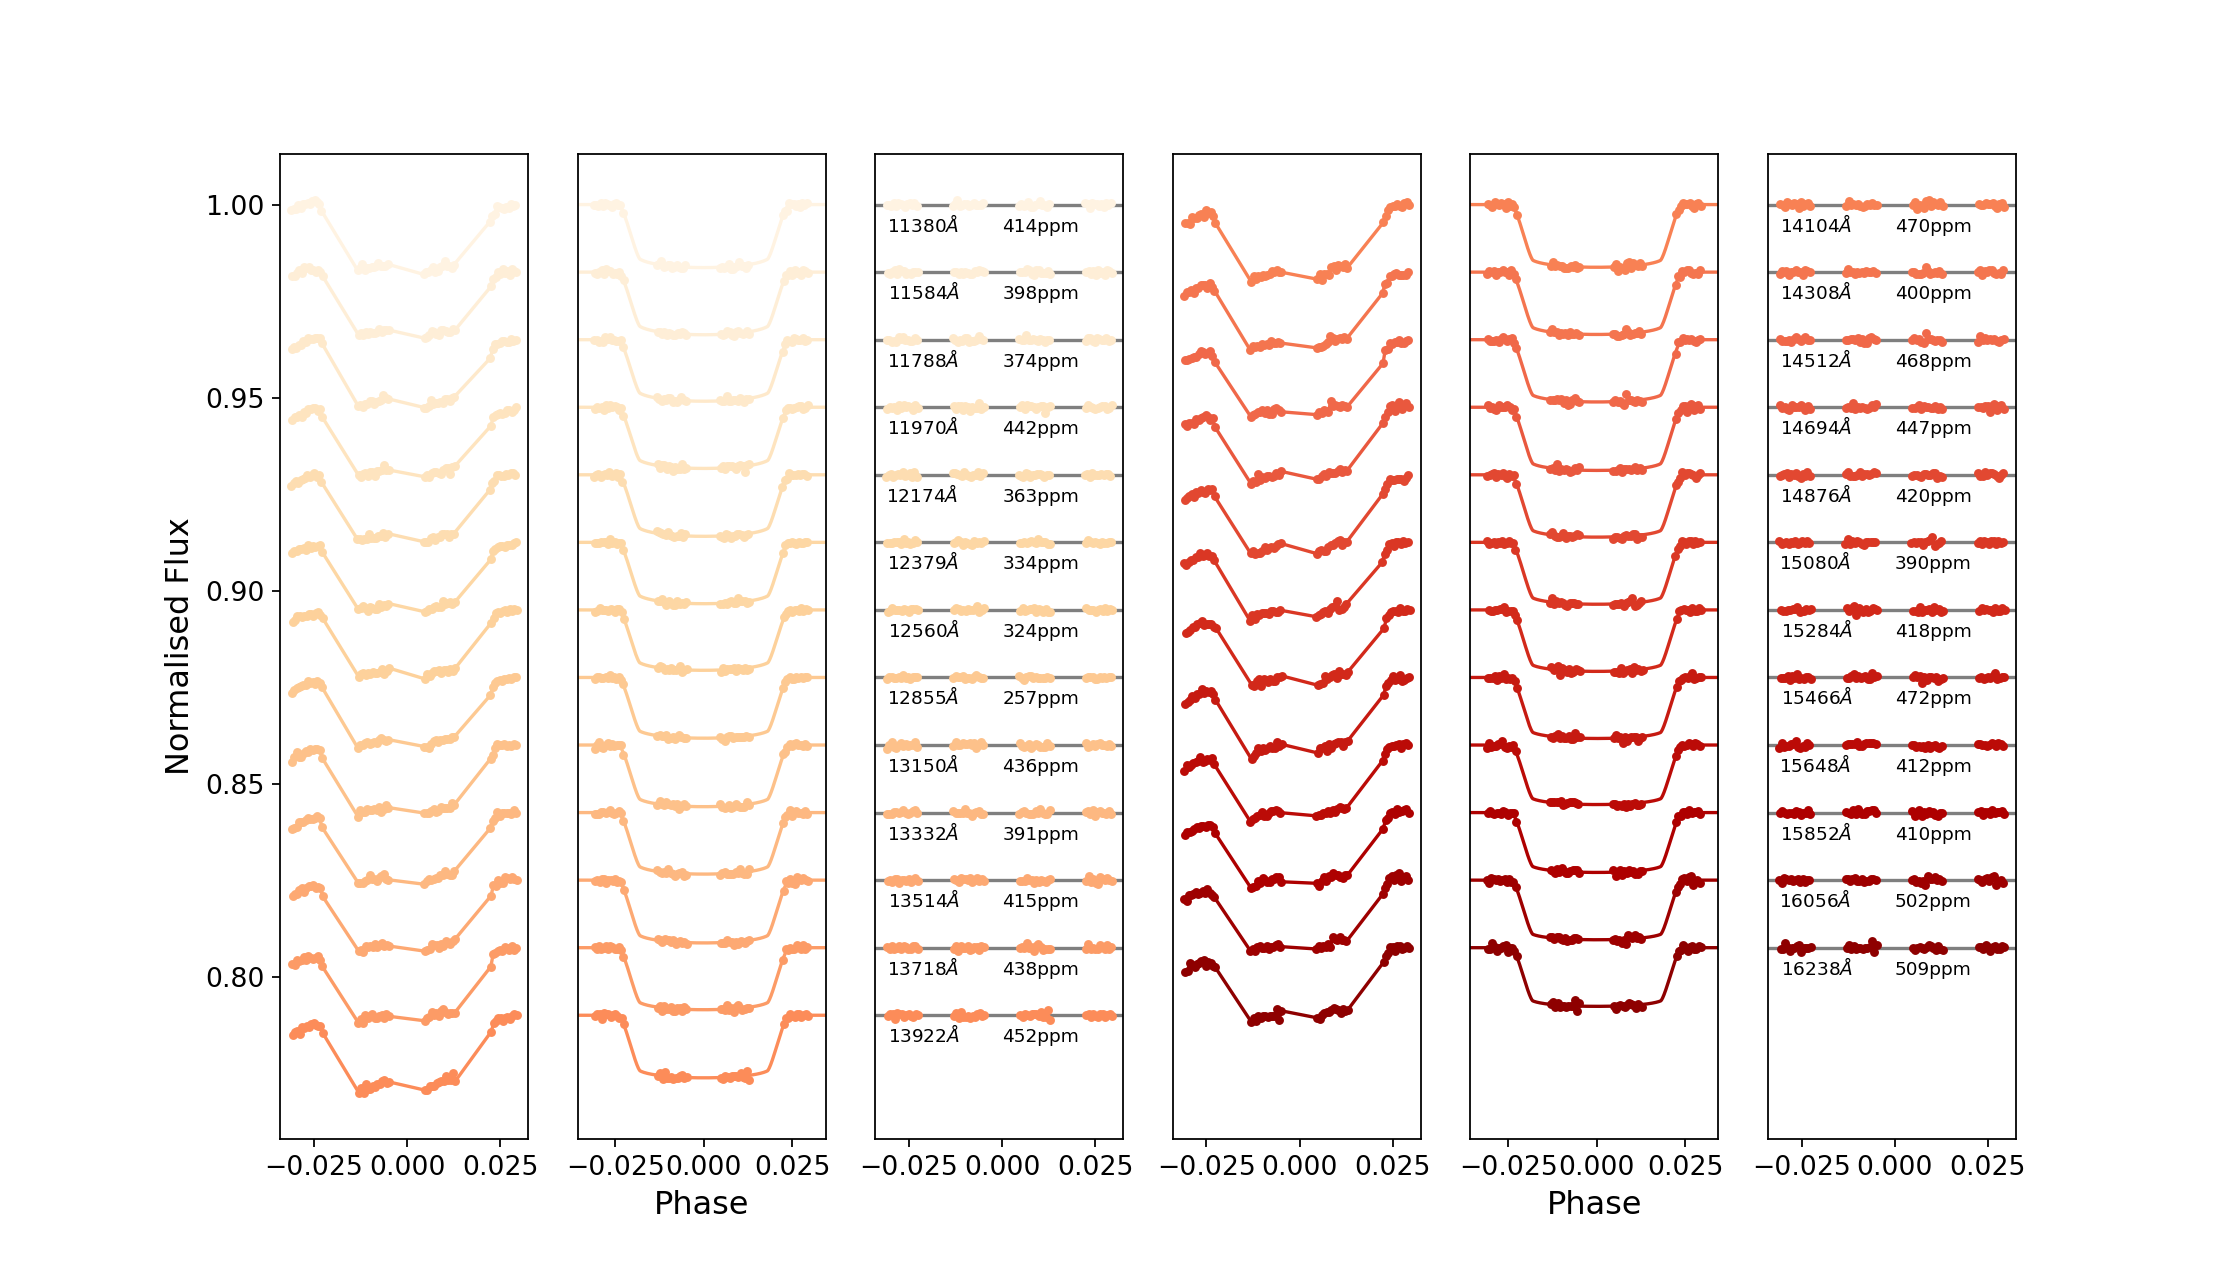

In [22]:
g141_resid, g141_wave, g141_hw = pretty_lcs_2panel(folders_g141, savefig=False, mode="WFC3_G141", figure_path='/Users/lilialderson/Documents/papers/WASP_17b_2021/github/', plot_output=True, palette='OrRd', squishfactor=0.0175, residuals_plot=False)

In [23]:
def pretty_lcs_STIS(folders_loc, savefig=False, mode="STIS_G430L_v5", figure_path='../../papers/WASP_17b_2021/', plot_output=True, palette='flare', squishfactor=0.01, residuals_plot=False):
    """
    Generates a 3 panel figure of raw light curves, cleaned light curves + model, 
    & residuals with residual stdev and wavelength centre printed underneath.
    
    Can also save residual map if required via residuals_plot = True
    
    Inputs: 
    - folders_loc (str)
        location of STIS files, e.g., "../../HST/WASP_17b/transit/STIS/G430L_Visit5/"
    - savefig (bool, default=False)
        whether to save the figure or not
    - mode (str)
        mode STIS was in, for save name
    - figure_path (str, default='../../papers/WASP_17b_2021')
        where to save the figure
    - plot_output (bool, default=True)
        whether to display figure via plt.show()
    - palette (str, default='flare')
        seaborn color palette to use for plotting
    - squishfactor (float, default='0.01')
        how much to offset each light curve, likely will only need changing if transit is particularly deep or raw light curves are particularly messy
    - residuals_plot (bool default=False)
        saves residual map as pdf
    
    Outputs:
    - all_residuals (array)
        frame X bin array of all residuals
    - wave_mid (array)
        centers of wavelength bins
        
    
    Seaborn options (+ all '_r' versions):
    'Accent', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap',  'Dark2', 'GnBu', 'Greens', 'Greys', 'OrRd', 
    'Oranges', 'PRGn', 'Paired', 'Pastel1', 'Pastel2', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 
    'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Set1', 'Set2', 'Set3', 'Spectral', 'Wistia', 'YlGn', 
    'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cividis', 'cool', 
    'coolwarm', 'copper', 'crest', 'cubehelix', 'flag', 'flare', 'gist_earth', 'gist_gray', 'gist_heat', 
    'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 
    'icefire', 'inferno', 'jet', 'magma', 'mako', 'nipy_spectral', 'ocean', 'pink', 'plasma', 'prism', 
    'rainbow', 'rocket', 'seismic', 'spring', 'summer', 'terrain', 'turbo', 'twilight', 'twilight_shifted', 
    'viridis', 'vlag', 'winter'
    """
    
    axes_go = False
    if savefig == True:
        axes_go = True
    if plot_output == True:
        axes_go = True
        
    if axes_go == True:
        fig, axes = plt.subplots(1, 3, figsize=(8,10),sharey=True)

    models_list = glob.glob(folders_loc+'*_bin*_model.txt')
    models_list.sort()

    lcs_list = glob.glob(folders_loc+'*_bin*_lightcurve.txt')
    lcs_list.sort()

    trans_file = glob.glob(folders_loc+'*L_transmission.txt')

    residual_len = len(np.loadtxt(lcs_list[0],unpack=True, usecols=5))
    all_residuals = np.zeros((residual_len,len(lcs_list)))
    
    wave_mid, wave_hw,_,_ = np.loadtxt(trans_file[0], unpack=True)
    wave_mid *=1e4
    wave_hw *=1e4
    #wave_half_width=[]

    count=0

    N = len(lcs_list)  # Number of wavelength bins
    colors = np.array(sns.color_palette(palette, N))

    for i in range(N):

        sys_phase, sys_rawflux, sys_rawflux_err, sys_flux, sys_flux_err, sys_residuals = np.loadtxt(lcs_list[i],unpack=True)

        sys_model_phase, sys_model = np.loadtxt(models_list[i],unpack=True)

        all_residuals[:,count] = sys_residuals

        residual_stdev = np.std(sys_residuals)# +1
        residual_stdev_ppm = residual_stdev*1e6

        xlim_min = np.min(sys_phase) - 0.005
        xlim_max = np.max(sys_phase) + 0.005

        if axes_go == True:
            axes[0].errorbar(sys_phase,(sys_rawflux-count*squishfactor),yerr=sys_rawflux_err,marker='.',ls='none',label="rawflux",alpha=1,c=colors[count])
            axes[0].plot(sys_phase,(sys_rawflux-count*squishfactor),ls='-',label="rawflux",alpha=1,c=colors[count])
            axes[0].set_ylabel("Normalised Flux",fontsize="x-large")
            axes[0].tick_params(axis='y', labelsize='large')
            axes[0].tick_params(axis='x', labelsize='large')

            axes[1].errorbar(sys_phase,(sys_flux-count*squishfactor),yerr=sys_flux_err,marker='.',ls='none',label="flux",alpha=1,c=colors[count])
            axes[1].plot(sys_model_phase,(sys_model-count*squishfactor),ls='-',label="model",alpha=1,c=colors[count])
            axes[1].set_xlim(xlim_min, xlim_max)
            axes[1].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
            axes[1].set_xlabel("Phase",fontsize="x-large")
            axes[1].tick_params(axis='x', labelsize='large')

            axes[2].axhline((1-count*squishfactor), ls='-', alpha=0.5, color='k')
            axes[2].errorbar(sys_phase,(1+(sys_residuals)-count*squishfactor),marker='.',ls='none',label="flux",alpha=1,c=colors[count])
            axes[2].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
            axes[2].tick_params(axis='x', labelsize='large')
            axes[2].annotate((str(int(wave_mid[count]))+"$\AA$"),xy=(np.min(sys_phase),(1-count*squishfactor-0.4*squishfactor)),fontsize='small')
            axes[2].annotate((str(int(residual_stdev_ppm))+"ppm"),xy=(0,(1-count*squishfactor-0.4*squishfactor)),fontsize='small')

        count+=1

    #axes[0].set_ylim(np.min(sys_rawflux-(count-1)*squishfactor)-0.003,1.005)

    if savefig == True:
        plt.savefig(figure_path+mode+"_pretty_slcs.pdf",bbox_inches='tight')
    if plot_output == True:
        plt.show()
        
    if residuals_plot == True:
        frames, bins = np.shape(all_residuals)
        frame_nos = np.arange(1,frames+1)
        colorrange = np.max([abs(np.amin(all_residuals)),abs(np.amax(all_residuals))])

        plt.figure(figsize=(7,5))
        im = plt.pcolormesh(wave_mid,frame_nos,(all_residuals*1e6), cmap='Spectral',edgecolors='face', shading='auto',vmin=-(colorrange*1e6), vmax=(colorrange*1e6))
        plt.ylabel("Frame Number")
        plt.xlabel("Wavelength ($\AA$)")#($\mu$m)")
        colorbar(im, "Residuals (ppm)")
        plt.savefig(figure_path+mode+"_residual_map.pdf",bbox_inches='tight')
        
    return(all_residuals, wave_mid, wave_hw)

<IPython.core.display.Javascript object>


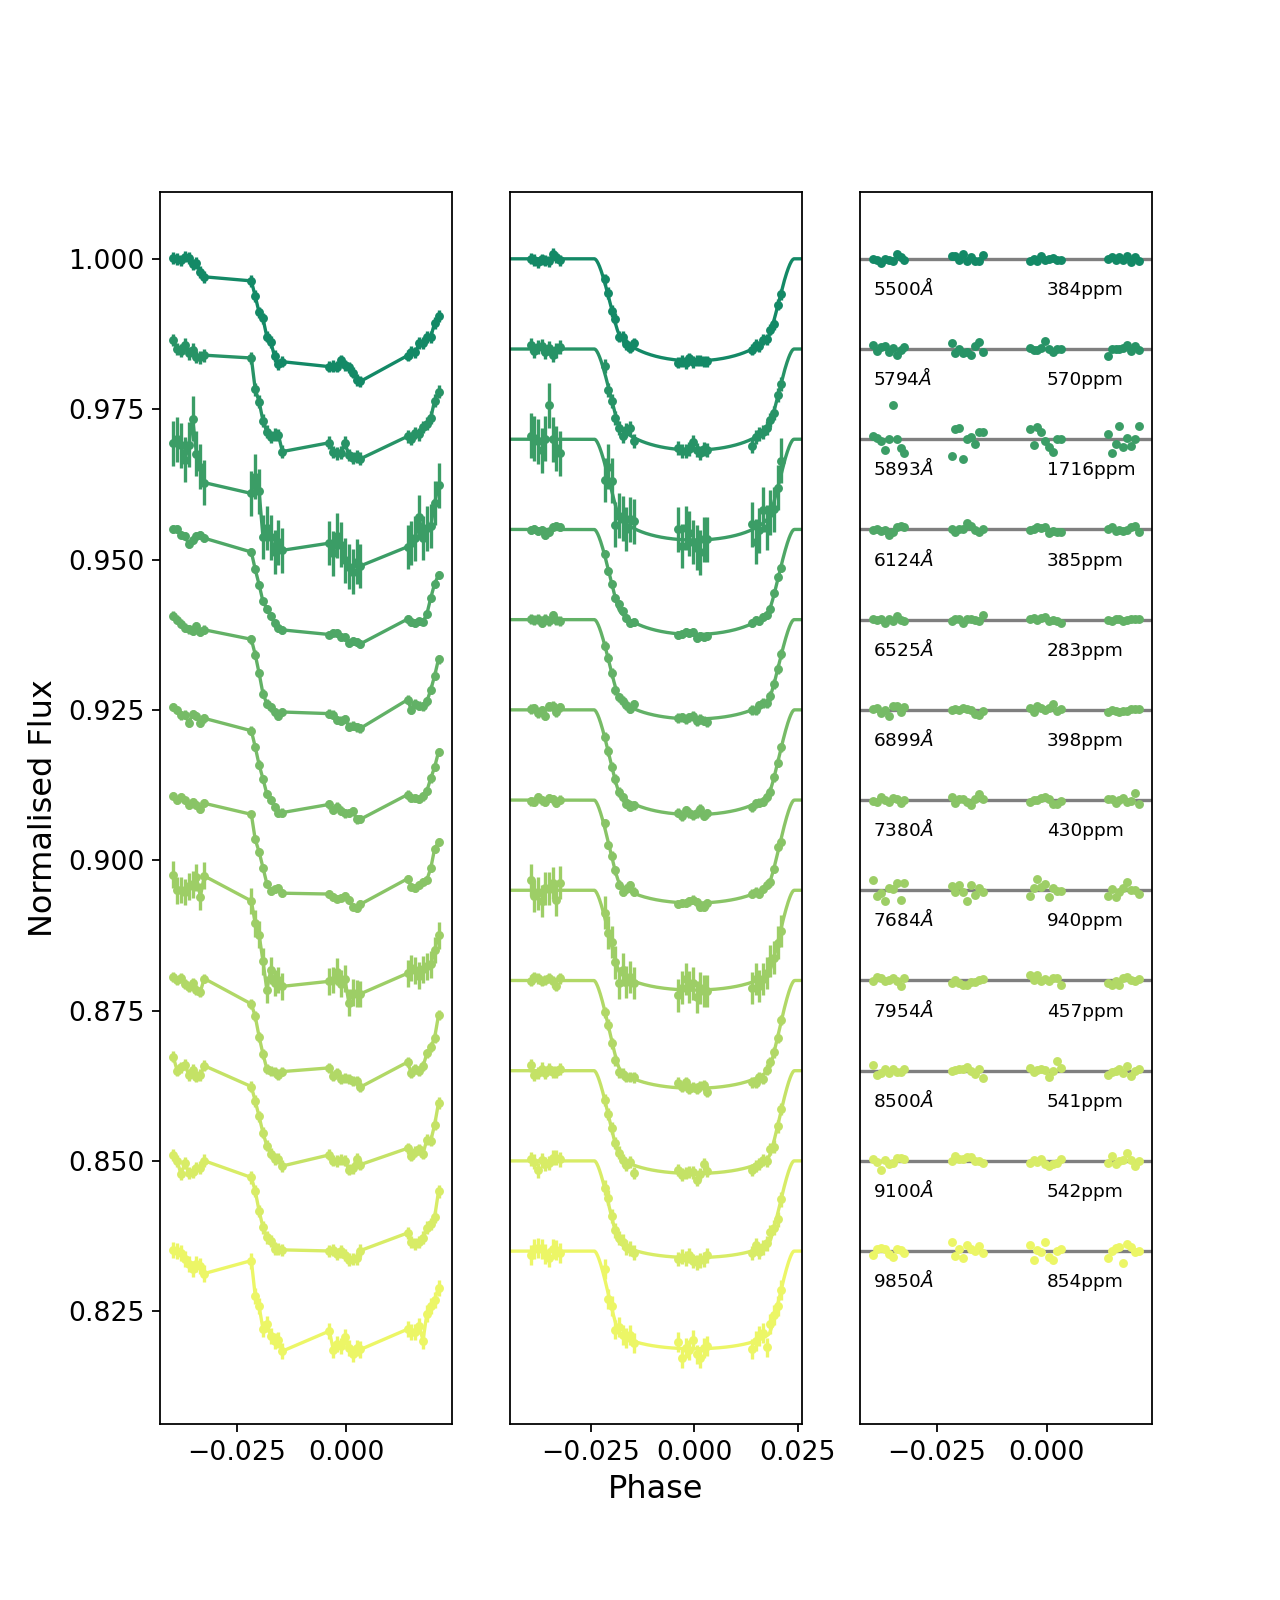

<IPython.core.display.Javascript object>


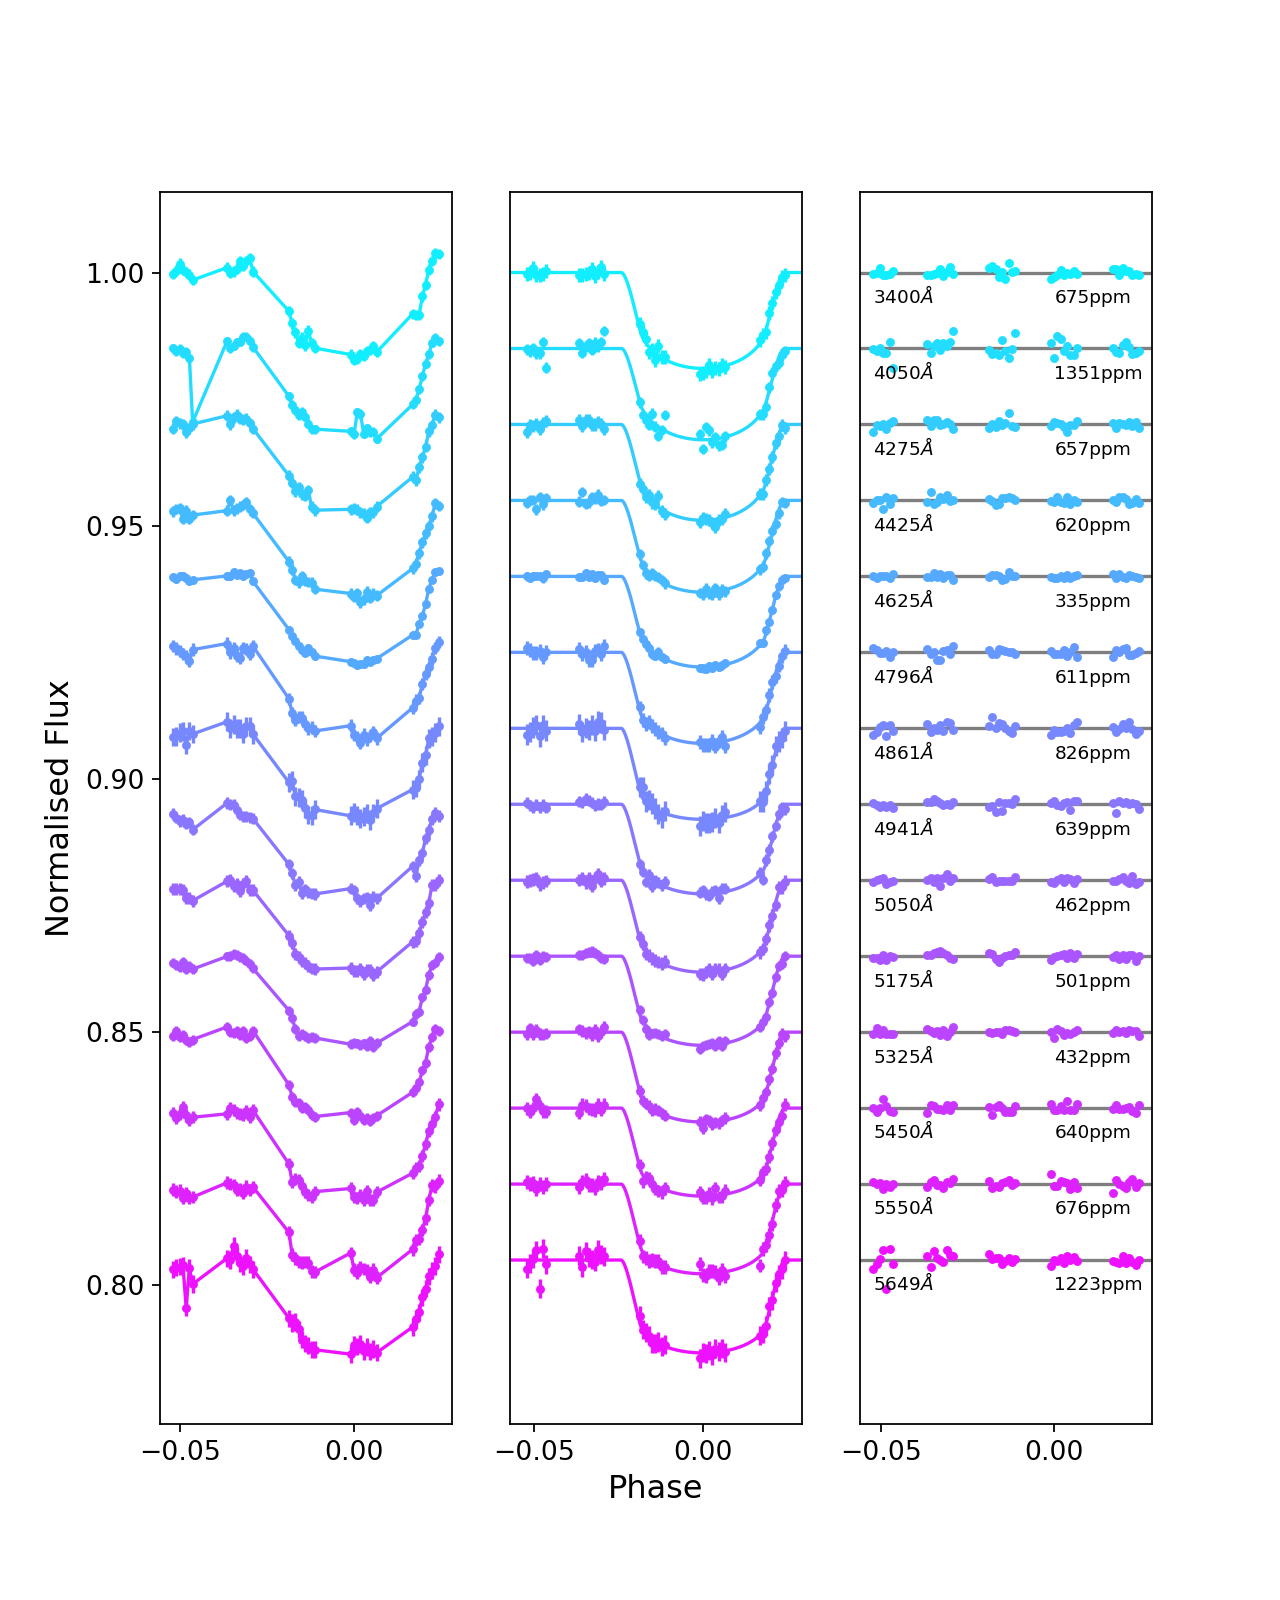

<IPython.core.display.Javascript object>


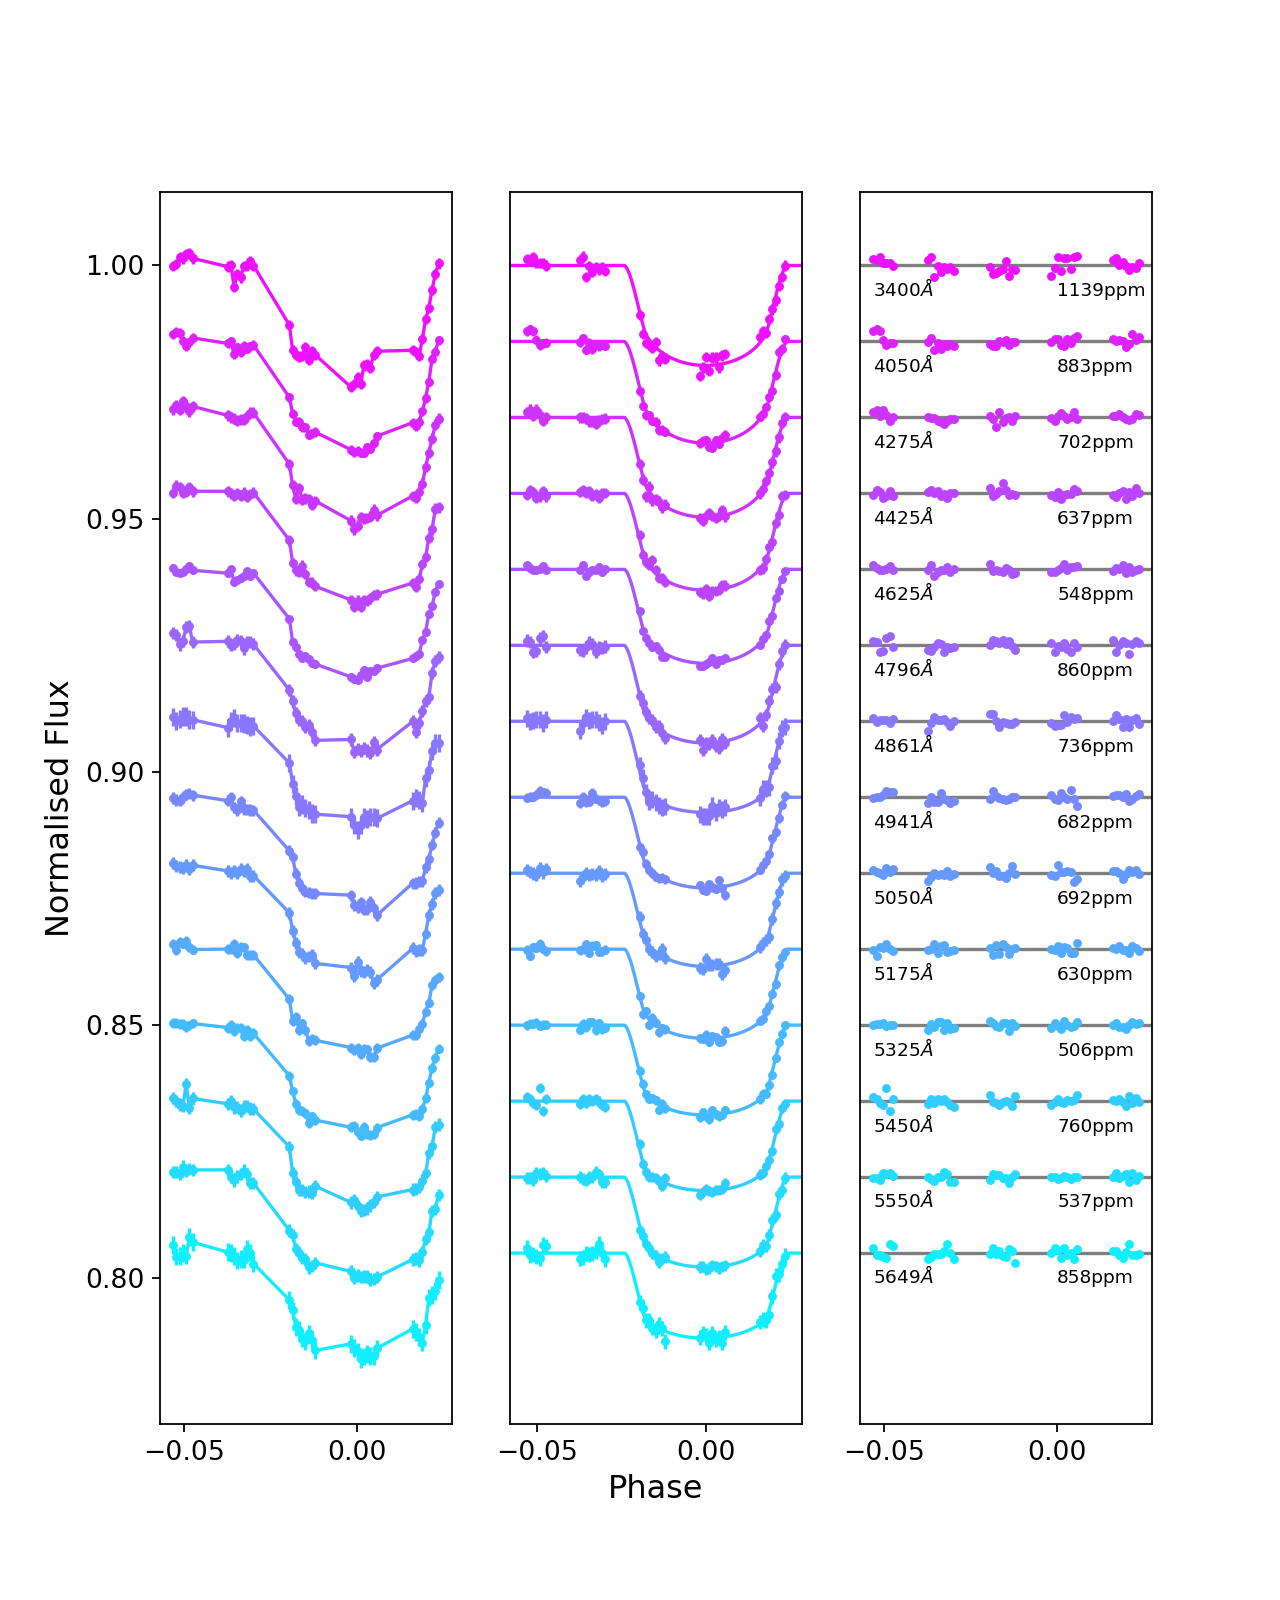

In [24]:
g750_resid, g750_wave, g750_hw = pretty_lcs_STIS("/Users/lilialderson/Documents/papers/WASP_17b_2021/github/FINAL_PERIOD_G750L_Visit19/", savefig=False, mode="STIS_G750L_v19", figure_path='/Users/lilialderson/Documents/papers/WASP_17b_2021/github/', plot_output=True, palette='summer', squishfactor=0.015, residuals_plot=False)
g435_resid, g435_wave, g435_hw = pretty_lcs_STIS("/Users/lilialderson/Documents/papers/WASP_17b_2021/github/FINAL_PERIOD_G430L_Visit5/", savefig=False, mode="STIS_G430L_v5", figure_path='/Users/lilialderson/Documents/papers/WASP_17b_2021/github/', plot_output=True, palette='cool', squishfactor=0.015, residuals_plot=False)
g436_resid, g436_wave, g436_hw = pretty_lcs_STIS("/Users/lilialderson/Documents/papers/WASP_17b_2021/github/FINAL_PERIOD_G430L_Visit6/", savefig=False, mode="STIS_G430L_v6", figure_path='/Users/lilialderson/Documents/papers/WASP_17b_2021/github/', plot_output=True, palette='cool_r', squishfactor=0.015, residuals_plot=False)